# Regridding CMIP6 data and finding the sea ice border

In [1]:
from pathlib import Path  #Object-oriented filesystem paths
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np

from __future__ import division

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#import sea_ice_ccn as ccn
import SI_border_functions as sib

from cmip6_preprocessing.preprocessing import correct_lon

import xesmf as xe

import nctoolkit as nc

import geopandas

from shapely.geometry import Point

from scipy.interpolate import NearestNDInterpolator

import cftime

import os


1 file was created by nctoolkit in prior or current sessions. Consider running deep_clean!
nctoolkit is using Climate Data Operators version 1.9.9


Get the siconc outputs from the cmip6 1% CO2 increase runs

In [2]:
files = [
    'siconc_SImon_AWI-ESM-1-1-LR_1pctCO2_r1i1p1f1_gn_185001-209912.nc',
    'siconc_SImon_CAMS-CSM1-0_1pctCO2_r1i1p1f1_gn_303001-317912.nc',
    'siconc_SImon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc',
    'siconc_SImon_CMCC-CM2-HR4_1pctCO2_r1i1p1f1_gn_191301-206312.nc',
    'siconc_SImon_E3SM-1-0_1pctCO2_r1i1p1f1_gr_000101-015012.nc',
    'siconc_SImon_EC-Earth3-AerChem_1pctCO2_r1i1p1f1_gn_185001-199912.nc',
    'siconc_SImon_EC-Earth3-Veg_1pctCO2_r1i1p1f1_gn_185001-200012.nc',
    'siconc_SImon_FIO-ESM-2-0_1pctCO2_r1i1p1f1_gn_000101-015012.nc',
    'siconc_SImon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr_000101-015012.nc',
    'siconc_SImon_GISS-E2-1-H_1pctCO2_r1i1p1f1_gr_185001-200012.nc',
    'siconc_SImon_ICON-ESM-LR_1pctCO2_r1i1p1f1_gn_185001-201912.nc',
    'siconc_SImon_INM-CM4-8_1pctCO2_r1i1p1f1_gr1_185001-199912.nc',
    'siconc_SImon_INM-CM5-0_1pctCO2_r1i1p1f1_gr1_185001-199912.nc',
    'siconc_SImon_IPSL-CM5A2-INCA_1pctCO2_r1i1p1f1_gn_185001-199912.nc',
    'siconc_SImon_IPSL-CM6A-LR_1pctCO2_r1i1p1f1_gn_185001-199912.nc',
    'siconc_SImon_MPI-ESM1-2-HR_1pctCO2_r1i1p1f1_gn_185001-201412.nc',
    'siconc_SImon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_185001-201412.nc',
    'siconc_SImon_MPI-ESM-1-2-HAM_1pctCO2_r1i1p1f1_gn_185001-199912.nc', 
    'siconc_SImon_MRI-ESM2-0_1pctCO2_r1i1p1f1_gn_185001-200012.nc', 
    'siconc_SImon_NESM3_1pctCO2_r1i1p1f1_gn_185001-199912.nc', 
    'siconc_SImon_NorCPM1_1pctCO2_r1i1p1f1_gn_000101-016412.nc', 
    'siconc_SImon_NorESM2-LM_1pctCO2_r1i1p1f1_gn_000101-015012.nc', 
    'siconc_SImon_NorESM2-MM_1pctCO2_r1i1p1f1_gn_000101-015012.nc', 
    'siconc_SImon_SAM0-UNICON_1pctCO2_r1i1p1f1_gn_185001-199912.nc', 
    'siconc_SImon_TaiESM1_1pctCO2_r1i1p1f1_gn_000101-015012.nc',
    "siconc_SImon_CMCC-CM2-SR5_1pctCO2_r1i1p1f1_gn_185001-201412.nc",
    #Error in netcdf: "siconc_SImon_CMCC-ESM2_1pctCO2_r1i1p1f1_gn_185001-201412.nc",
    "siconc_SImon_GFDL-CM4_1pctCO2_r1i1p1f1_gr_000101-015012.nc",
    #empty: "siconc_SImon_MIROC6_1pctCO2_r1i1p1f1_gn_320001-334912.nc",
    #"siconc_SImon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_185001-201412.nc"
]

In [3]:
names = ["AWI-ESM-1-1-LR",    
    'CAMS-CSM1-0',
    'CanESM5',
    'CMCC-CM2-HR4',
    'E3SM-1-0',
    'EC-Earth3-AerChem',
    'EC-Earth3-Veg',
    'FIO-ESM-2-0',
    'GFDL-ESM4',
    'GISS-E2-1-H',
    'ICON-ESM-LR',
    'INM-CM4-8',
    'INM-CM5-0',
    'IPSL-CM5A2-INCA',
    'IPSL-CM6A-LR',
    'MPI-ESM1-2-HR',
    'MPI-ESM1-2-LR',
    'MPI-ESM-1-2-HAM', 
    'MRI-ESM2-0', 
    'NESM3', 
    'NorCPM1', 
    'NorESM2-LM', 
    'NorESM2-MM', 
    'SAM0-UNICON', 
    'TaiESM1',
    "CMCC-CM2-SR5",
    #"CMCC-ESM2",
    "GFDL-CM4"]
    #"MIROC6",
    #"MPI-ESM1-2-LR"]

In [4]:
#Open files from computer
path=r'/media/clara/Seagate/siconc_1pctCO2/'
Path(path).mkdir(parents=True, exist_ok=True)

dsets = []
for i,file in enumerate(files):
    dwt=path+file
    #open dataset and save in array
    print(i)
    dset = xr.open_dataset(dwt, decode_times=True, use_cftime=True)
    
    dsets.append(dset)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [5]:
#grid types: 0: lat/lon, 1: 1D, 2: 2D
types = [1,2,2,2,0,2,2,2,0,0,1,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,0]

In [6]:
#how to get the SI area
area_via = [None,
            "areacello",
            "areacello",
            "areacello",
            "areacello",
            "areacello",
            "areacello",
            "areacello",
            "areacello",
            "areacello", 
            None,
            "siarean",
            "siarean",
            "areacello",
            "siarean",
            "siarean",
            None,
            None,
            "siarean",
            "areacello",
            None,
            "siarean",
            "siarean",
            "areacello",
            "areacello",
            "areacello",
            "areacello",
            ]
#print(len(files), len(area_via))

Change coordinate names of some models, to have the same (at least for each grid type)

In [7]:
#rename model coordinates to i, lat, lon and create list
dsets[0] = dsets[0].rename({"ncells":"i"})
dsets[0] = correct_lon(dsets[0])

dsets[10] = dsets[10].rename({"latitude":"lat", "longitude":"lon"})
dsets[10] = correct_lon(dsets[10])

In [8]:
models_2D_j_i = [1,2,5,6,7,15,16,17,20,21,22,23,24,27]


dsets[13] = dsets[13].rename({"y":"j", "x":"i", "nav_lat": "latitude", "nav_lon": "longitude"})
dsets[14] = dsets[14].rename({"y":"j", "x":"i", "nav_lat": "latitude", "nav_lon": "longitude"})
dsets[18] = dsets[18].rename({"y":"j", "x":"i"})
dsets[19] = dsets[19].rename({"nj":"j", "ni":"i", "lat": "latitude", "lon": "longitude"})
dsets[3] = dsets[3].rename({"i":"j", "j":"i"})
dsets[25] = dsets[25].rename({"i":"j", "j":"i"})

for i,type in enumerate(types):
    if type == 2:
        model = dsets[i]
        dsets[i] = dsets[i].rename({"latitude":"lat", "longitude":"lon"})
        dsets[i] = correct_lon(dsets[i])

define model class

In [9]:
class model:
    def __init__(self,name,gridtype, model,file,areavia):
        self.name = name
        self.type = gridtype
        self.model = model
        self.file = file
        self.areavia = areavia
        self.T = None
        self.n = None
        self.center = None
        self.border = None

create list of model class objects

In [10]:
tstart=8
tstep=12
thlong=1   #10 #5

models = []
for i in range(len(files)):
    if i !=3: 
        #print(i)
        m = model(names[i], types[i], dsets[i], files[i], area_via[i])
        m.T = len(m.model.time.data[tstart::tstep])
        if m.type == 0:
            m.n = len(m.model.lon.data[::thlong])
        else:
            m.n = len(np.arange(np.nanmin(m.model.lon.data),np.nanmax(m.model.lon.data), step =thlong))
        models.append(m)


### regrid all the 2D models (except for no. 21) to 1.5 deg resolution with CDO

In [11]:
for i,m in enumerate(models):
    if m.type == 2 and i != 21:
        print(i)
        filename = "cdo_regridded_1_5_deg_" + m.name
        if os.path.exists(filename):
            print("open existing data")
            dr_out = xr.open_dataset(filename)
            setattr(m,"re_model_1_5", dr_out)
        else:
            print('create the dataset')
            ds = nc.open_data(path+m.file)

            ds.to_latlon(lon = [-180, 180], lat = [-90, 90], res = 1.5)
            print('save to netcdf')
            ds.to_nc(filename)
            ds_out = xr.open_dataset(filename, decode_times=True, use_cftime=True)
            print('add attribute')
            setattr(m,"re_model_1_5", ds_out)

1
open existing data
2
open existing data
4
open existing data
5
open existing data
6
open existing data
12
open existing data
13
open existing data
14
open existing data
15
open existing data
16
open existing data
17
open existing data
18
open existing data
19
open existing data
20
open existing data
22
open existing data
23
open existing data
24
open existing data


plot:

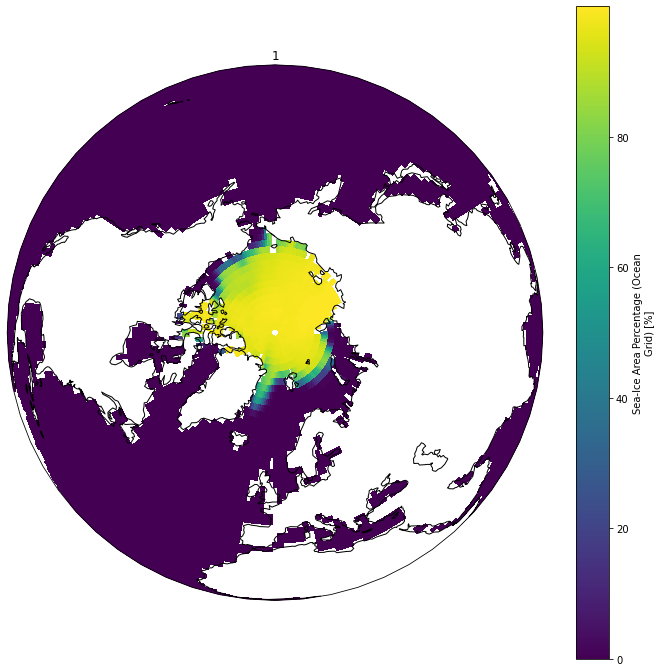

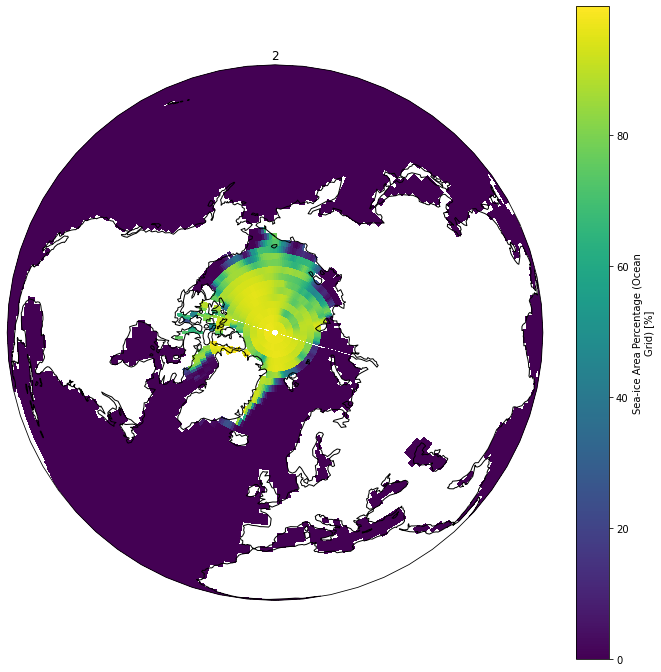

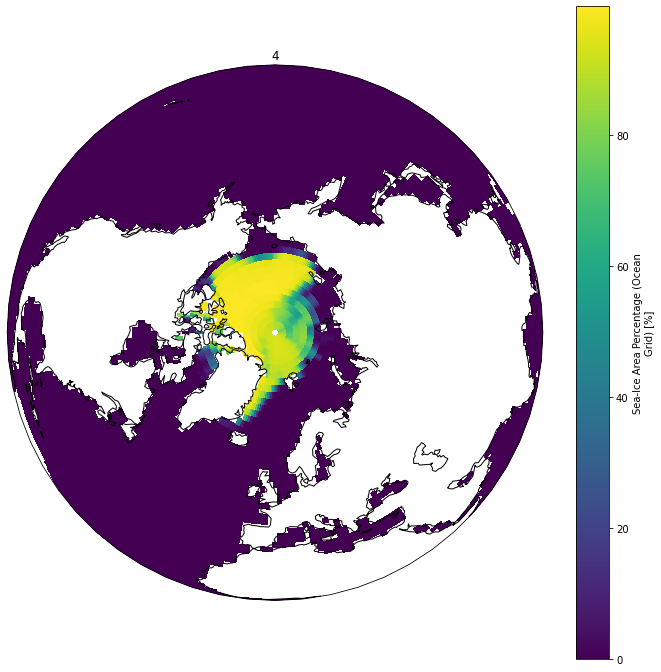

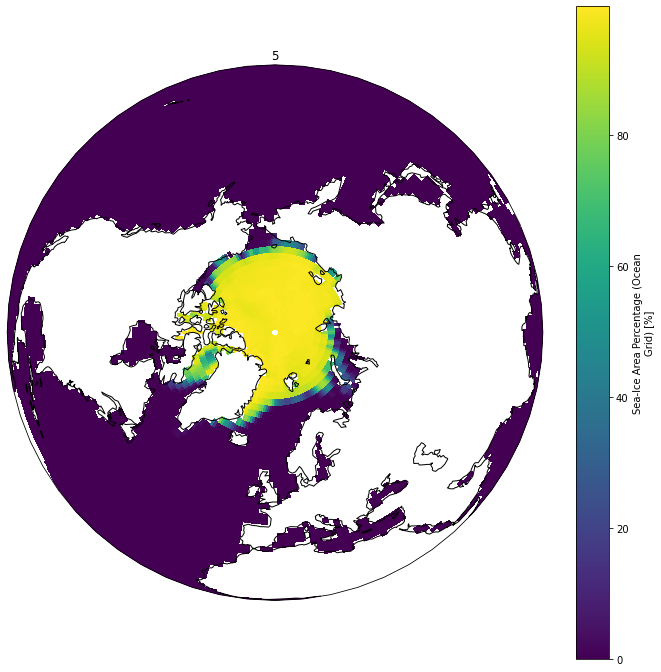

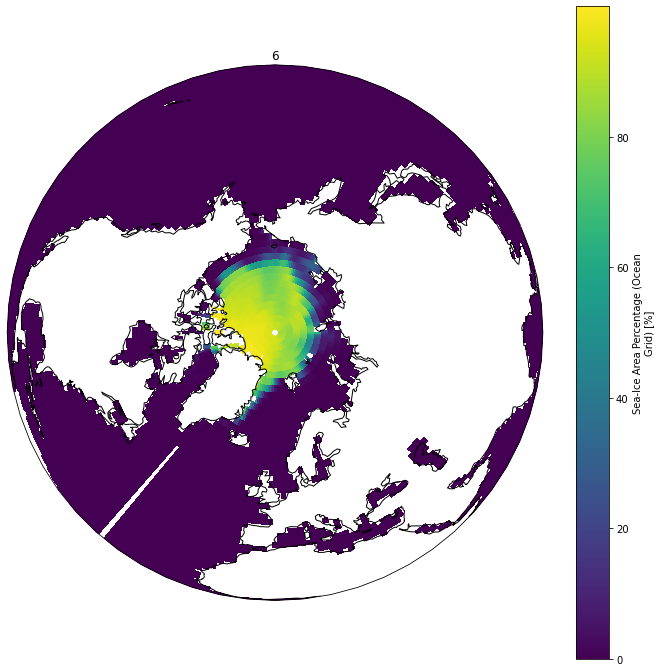

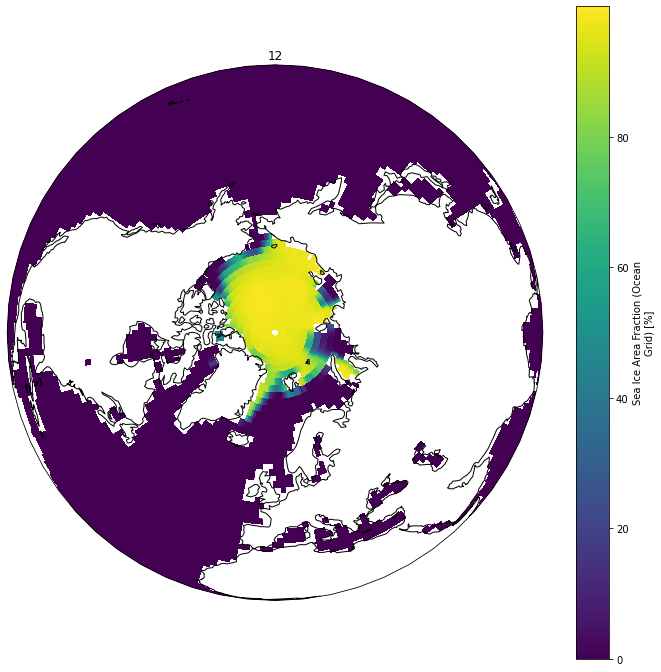

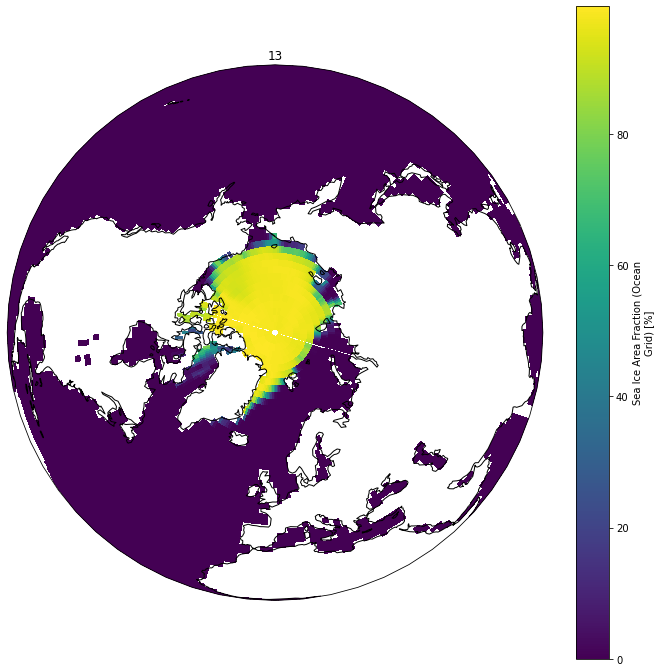

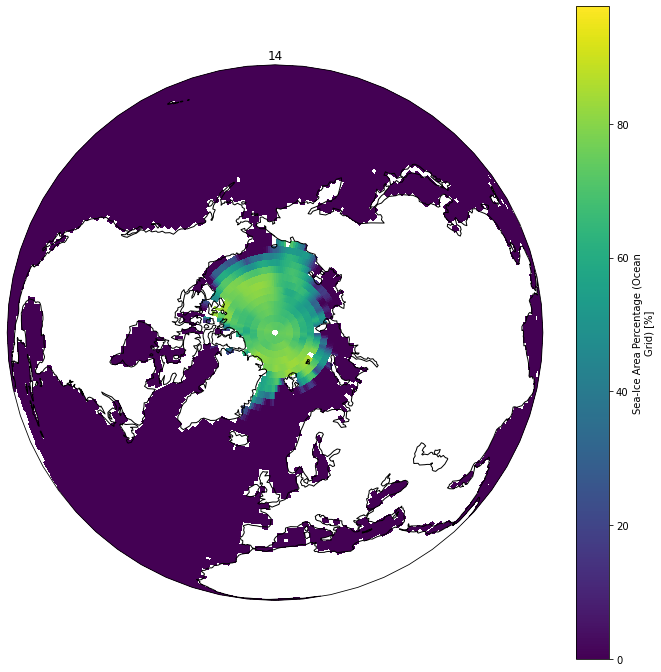

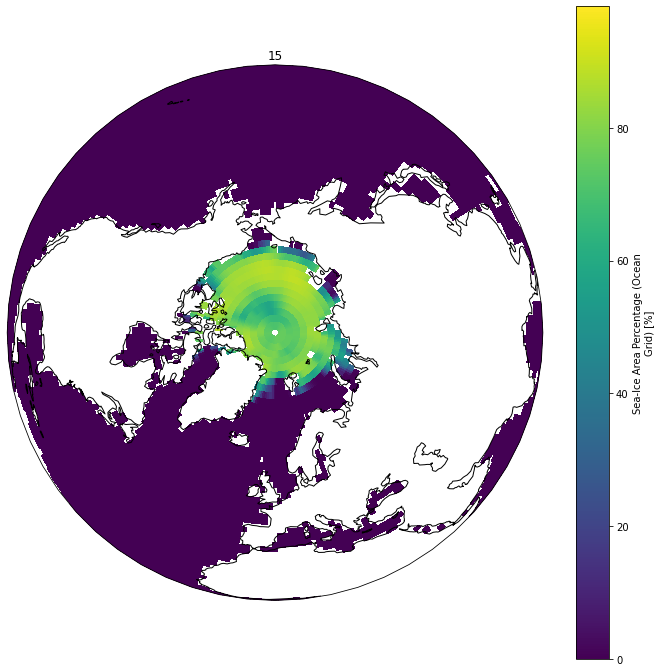

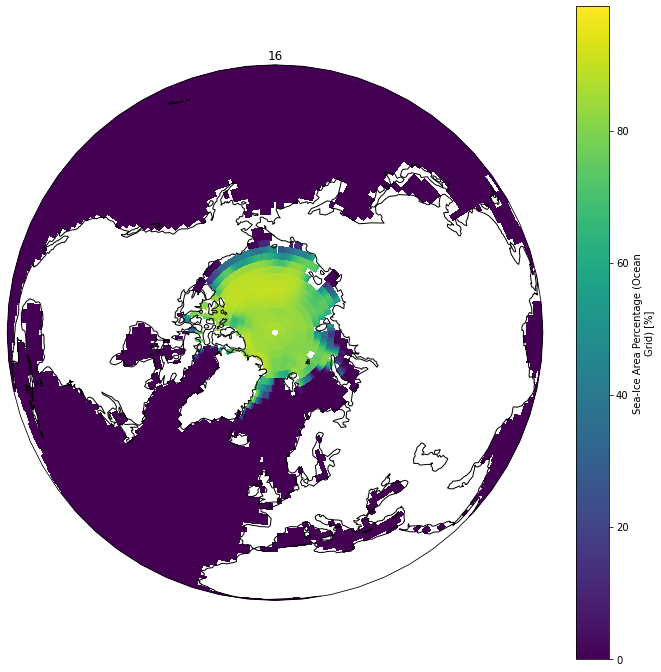

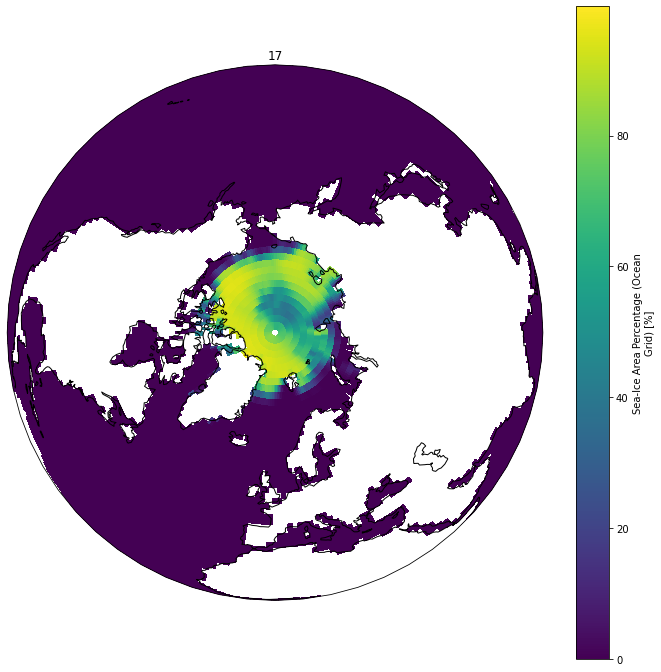

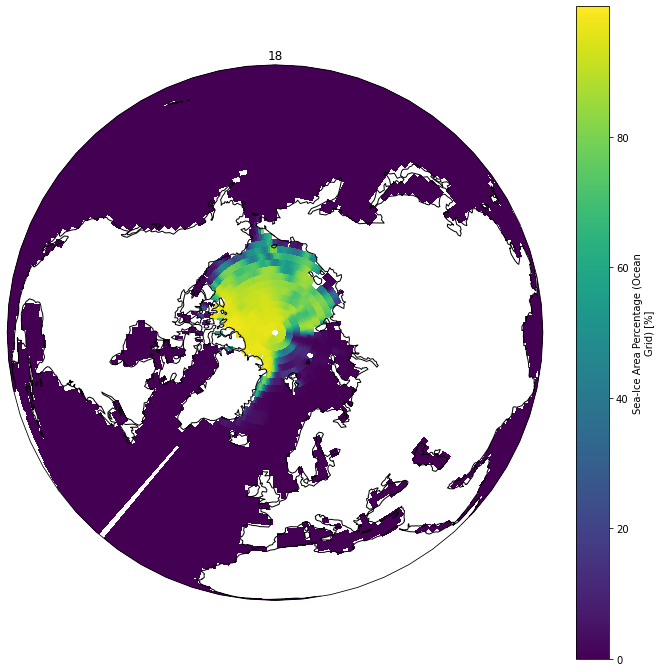

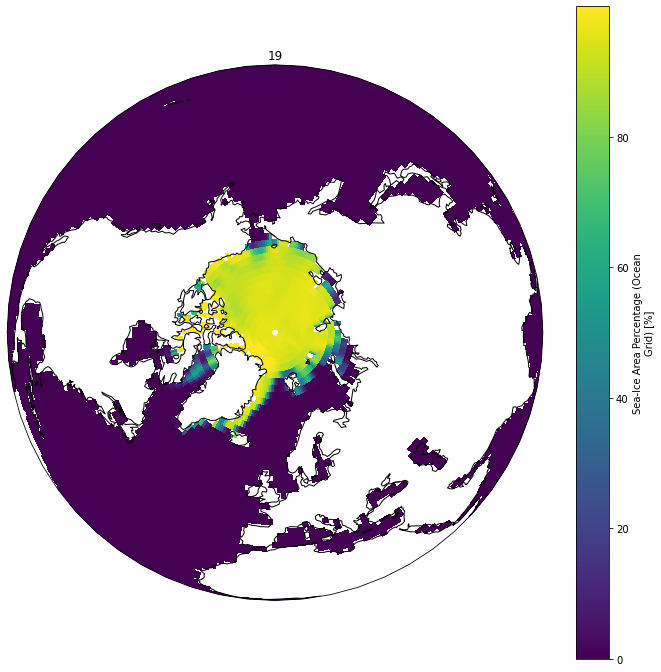

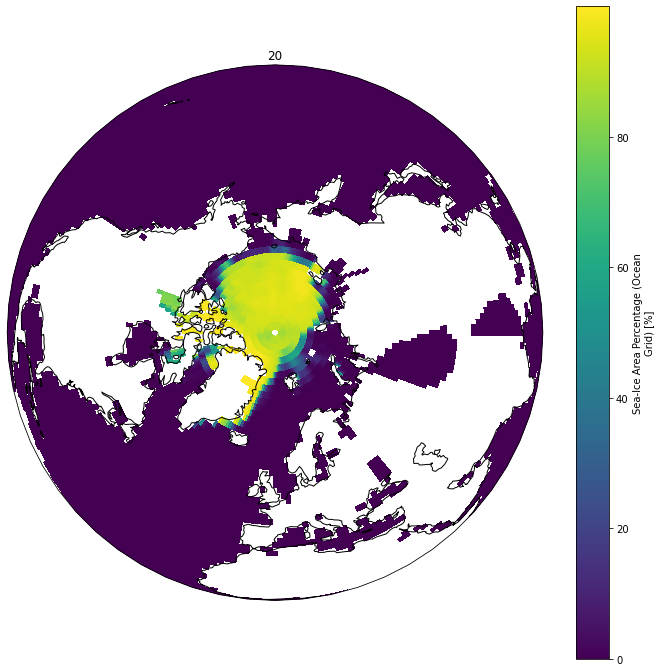

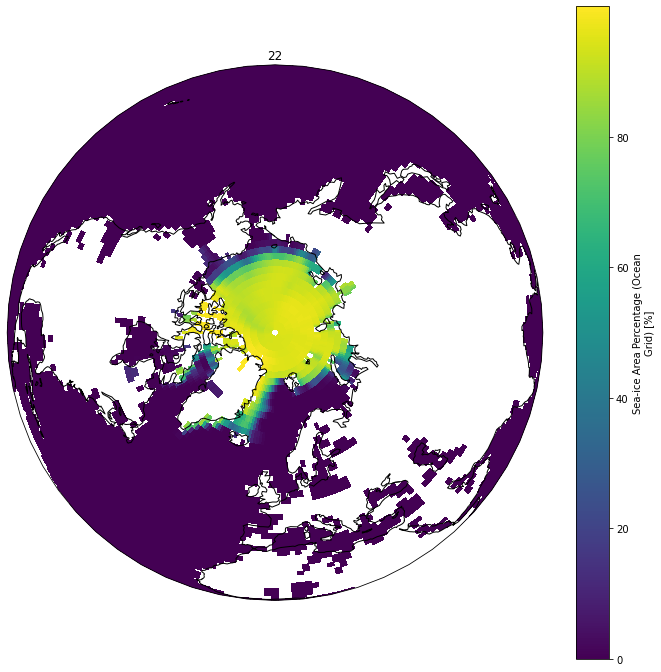

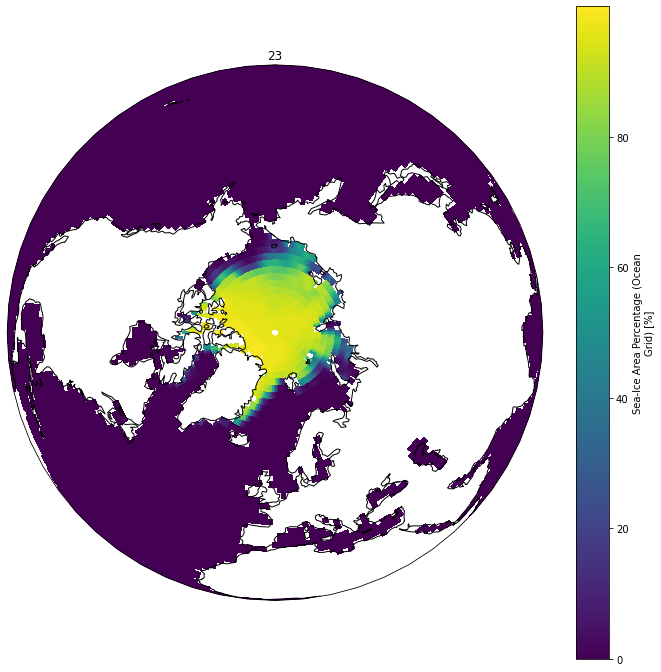

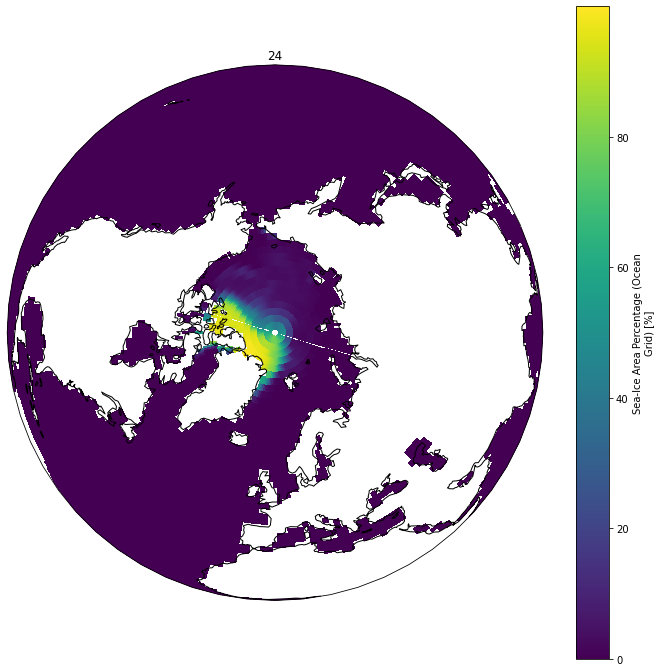

In [12]:
for i,m in enumerate(models):
    if m.type ==2 and i != 21:     
        fig = plt.figure(figsize=[12,12])

        ax=fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
        m.re_model_1_5.siconc.isel(time=8).plot(ax = ax, transform=ccrs.PlateCarree())
        plt.title(i)
        ax.coastlines()

## regrid lat lon models (without model 7 which has nans all over...) using xesmf to a 1.5 deg grid:

#### decide if grid to 90 or to 89.25 degrees N

In [13]:
print("average distance of maxlat to 90: ",np.mean([np.abs(np.nanmax(m.model.lat) - 90) for m in models]))
print("average distance of maxlat to 89.25: ", np.mean([np.abs(np.nanmax(m.model.lat) - 89.25) for m in models]))

average distance of maxlat to 90:  0.2981334010150789
average distance of maxlat to 89.25:  0.4518665989849211


In [14]:
whichcloser = [np.argmin([np.abs(np.nanmax(m.model.lat) - 90), np.abs(np.nanmax(m.model.lat) - 89.25)]) for m in models] #0 if closer to 90, 1 if closer to 89.25
print(np.count_nonzero(whichcloser) / len(whichcloser), "pct of models have max latitude closer to 89.25 deg")
print((len(whichcloser) - np.count_nonzero(whichcloser)) / len(whichcloser), "pct of models have max latitude closer to 90 deg")

0.2692307692307692 pct of models have max latitude closer to 89.25 deg
0.7307692307692307 pct of models have max latitude closer to 90 deg


--> regrid to -90,90

#### Regrid to 1.5 deg

In [15]:
# target grid is 1.5x1.5 degree rectilinear (same as for the 2D models)
target_grid = models[1].re_model_1_5.isel(time=0)
for i, m in enumerate(models):
    if m.type ==0 and i !=7:
        print(i)
        filename = "cdo_regridded_1_5_deg_" + m.name
        if os.path.exists(filename):
            print("open existing data")
            dr_out = xr.open_dataset(filename)
            setattr(m,"re_model_1_5", dr_out)
        else:
            print('create the dataset')
            regridder = xe.Regridder(m.model, target_grid, 'bilinear', periodic=True)
            dr_out = regridder(m.model)
            print('save to netcdf')
            dr_out.to_netcdf(filename)
            print('add attribute')
            setattr(m,"re_model_1_5", dr_out)

3
open existing data
8
open existing data
10
open existing data
11
open existing data
25
open existing data


plot

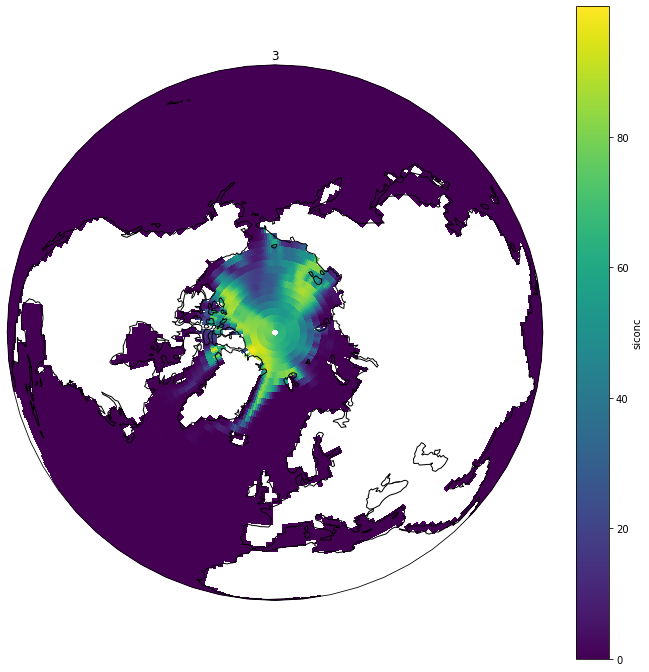

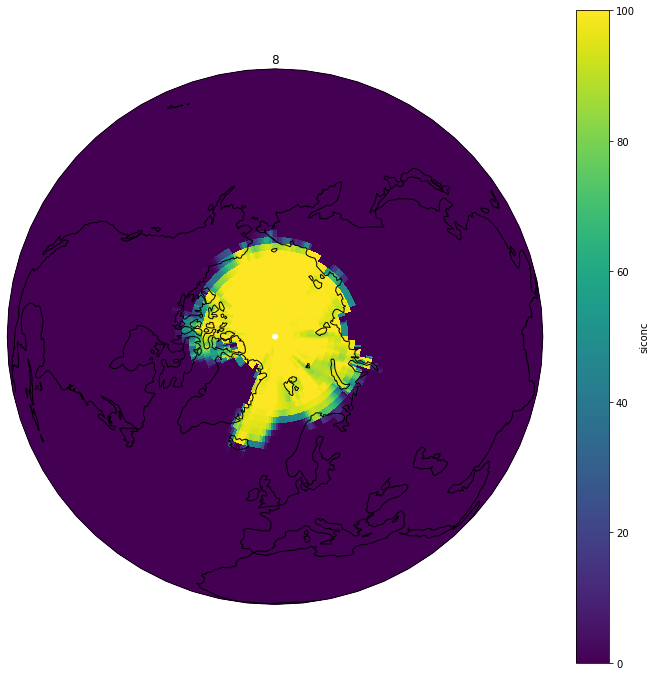

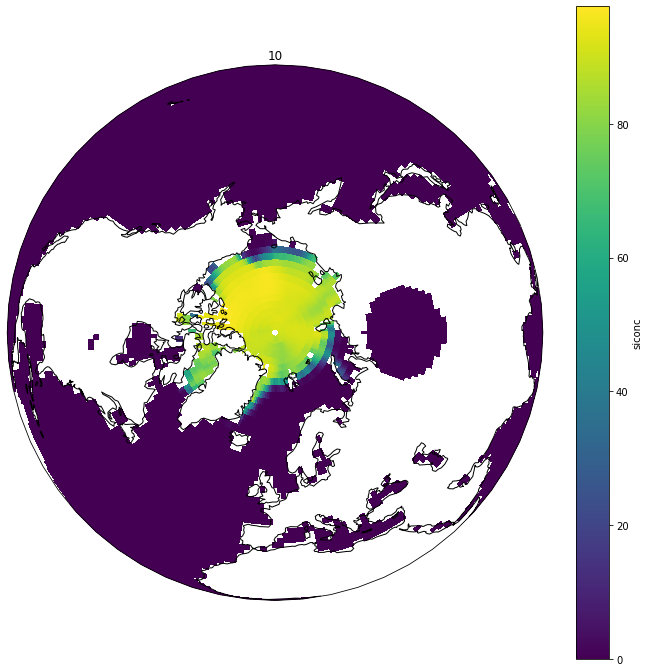

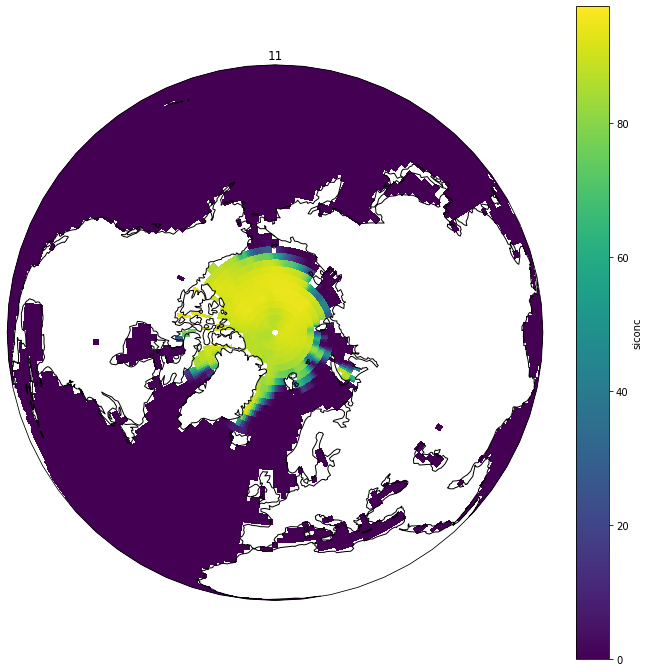

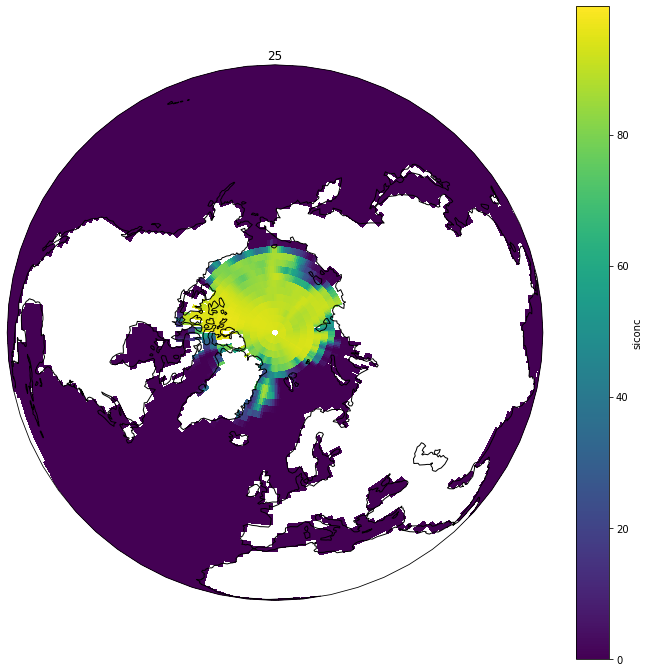

In [16]:
for i,m in enumerate(models):
    if m.type == 0 and i != 7:     
        fig = plt.figure(figsize=[12,12])

        ax=fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
        m.re_model_1_5.siconc.isel(time=8).plot(ax = ax, transform=ccrs.PlateCarree())
        plt.title(i)
        ax.coastlines()

## 1D models

Not implemented yet -> TO DO!!

For now, set those models and model 7 and 21 regridded model to nan

In [17]:
for i,m in enumerate(models):
    if m.type == 1 or i in [7,21]:
        setattr(m,"re_model_1_5", None)

# Apply landmask and interpolate the Nan values in the ocean

In [18]:
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
arctic = world.query('name in ["Greenland","Canada", "Russia", "United States of America", "Iceland", "Norway", "Finland", "Sweden", "Denmark", "United Kingdom", "Ireland" ]' )

In [19]:
gridding = 1.5
for mm,m in enumerate(models):
    if m.re_model_1_5:
        print(mm)
        filename = "masked_regridded_"+ m.name
        if os.path.exists(filename):
            print("open existing data")
            SI_masked= xr.open_dataset(filename)
            setattr(m,"SI_masked", SI_masked)
        else:
            print('create the dataset')
            print('add landmask')
            ###### add the same landmask everywhere ############
            SI = m.re_model_1_5.siconc.data.copy()
            land_lo = []
            land_la =[]
            #for i,la in enumerate(m.re_model_1_5.lat.data[int((90+60)/gridding):]): #only if above 60 degrees
            for i,la in enumerate(m.re_model_1_5.lat.data): #everywhere
                for j,lo in enumerate(m.re_model_1_5.lon.data):
                    #for land in arctic["geometry"].values:
                    for land in world["geometry"].values:
                        if Point(lo,la).within(land):
                            #SI[:,i+int((90+60)/gridding),j] = np.nan #if above 60
                            SI[:,i,j] = np.nan #for the everywhere case
                            land_lo.append(j)
                            land_la.append(i)
            print('delete NaNs in the ocean')
            ##### delete Nan values in the ocean #######
            ## create mask
            data = SI#[t,:,:]
            mask = np.where(~np.isnan(data[0])) #where not nan
            mask_t = np.transpose(mask)
            for k in np.transpose([land_la, land_lo]): #add points where on land
                mask_t = np.vstack((mask_t,k))
            ## interpolate
            for t in range(len(m.re_model_1_5.time)): 
                interp = NearestNDInterpolator(mask_t, data[t][(np.transpose(mask_t)[0], np.transpose(mask_t)[1])])
                SI[t,:,:] = interp(*np.indices(data[t].shape))

            print('create the dataset')
            ## create yet another xarray with the new siconc data stored in SI
            SI_masked = xr.Dataset(data_vars = dict(
                            siconc = (["time", "lat", "lon"],SI)),
                        #dims = ["time", "lat", "lon"],
                        coords = dict(
                            time = m.re_model_1_5.time.data,
                            lat = m.re_model_1_5.lat.data,
                            lon = m.re_model_1_5.lon.data
                        ))
            setattr(m,"SI_masked", SI_masked)
            print('save')
            SI_masked.to_netcdf(filename)
    else:
        setattr(m,"SI_masked", None)

1
open existing data
2
open existing data
3
open existing data
4
open existing data
5
open existing data
6
open existing data
8
open existing data
10
open existing data
11
open existing data
12
open existing data
13
open existing data
14
open existing data
15
open existing data
16
open existing data
17
open existing data
18
open existing data
19
open existing data
20
open existing data
22
open existing data
23
open existing data
24
open existing data
25
open existing data


plot:

/tmp/ipykernel_65160/258611590.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


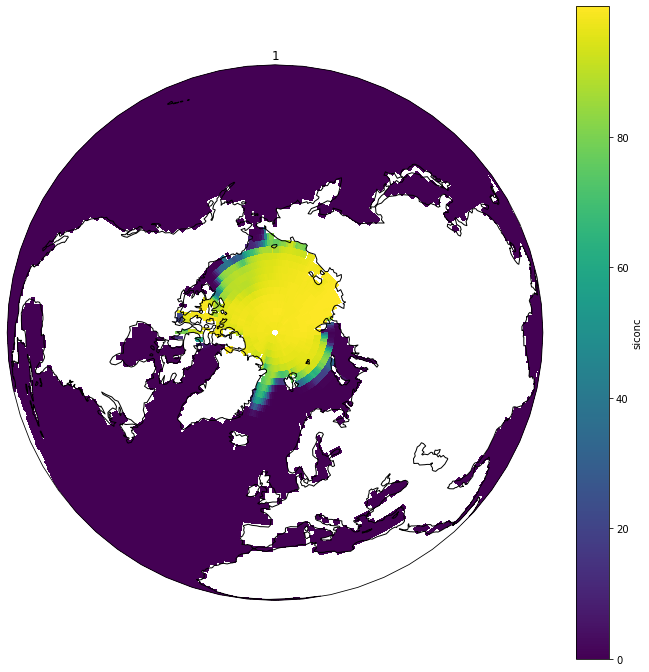

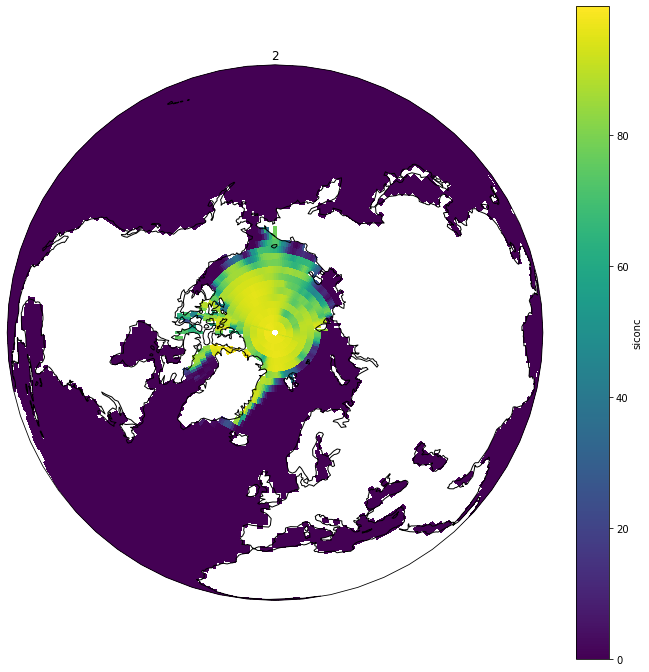

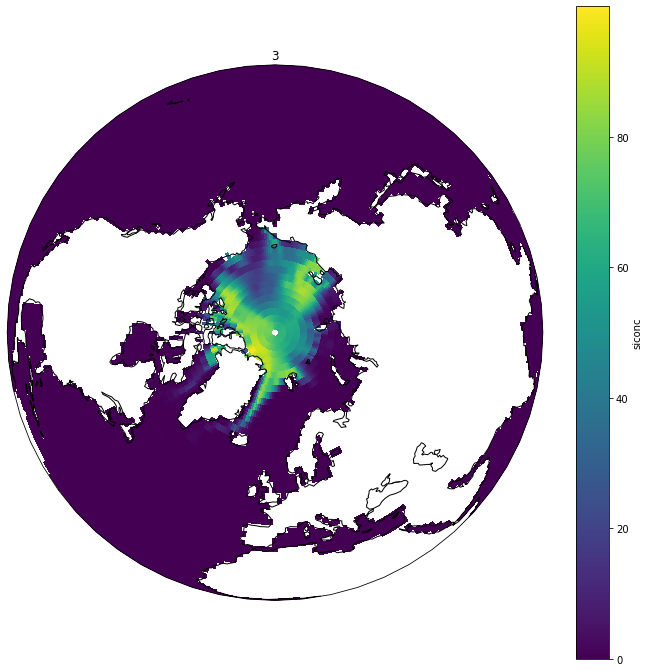

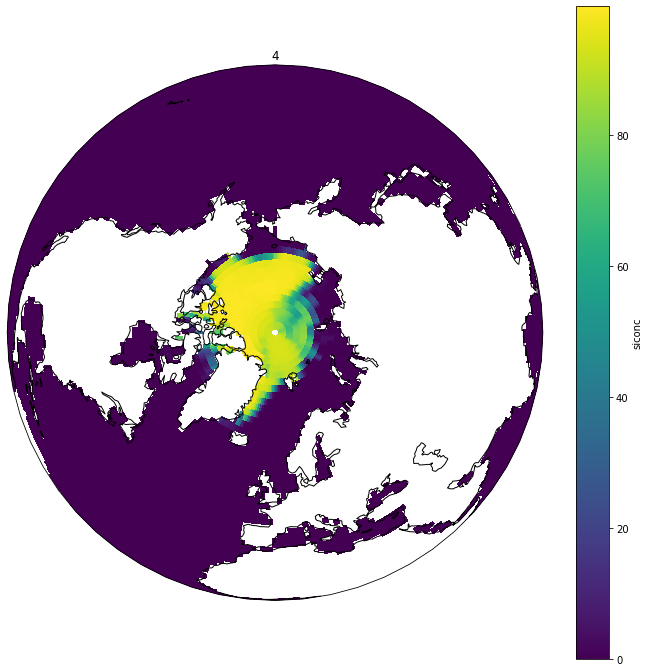

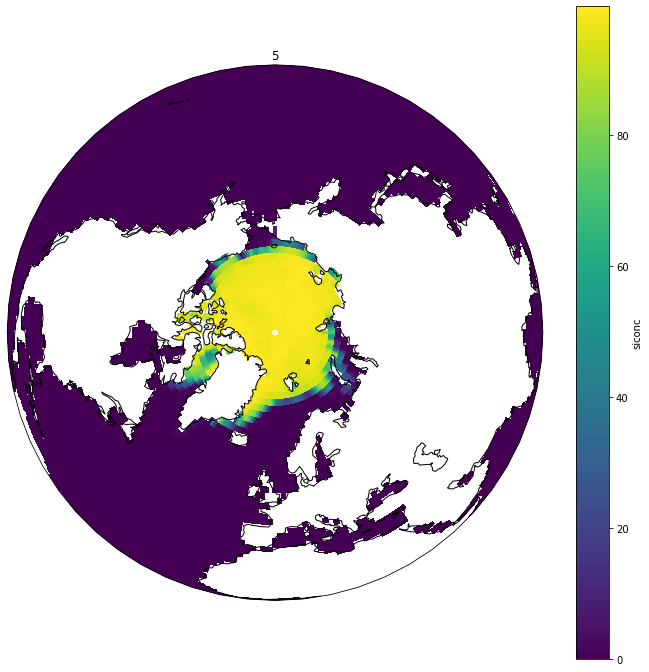

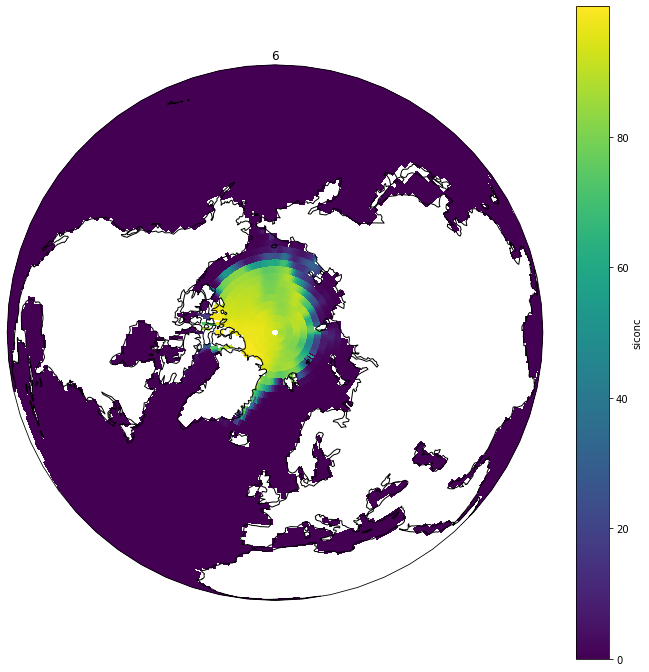

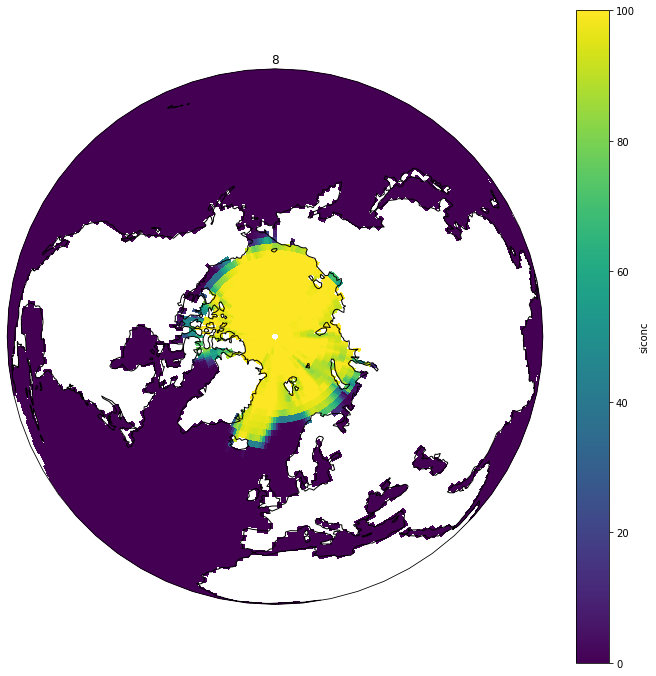

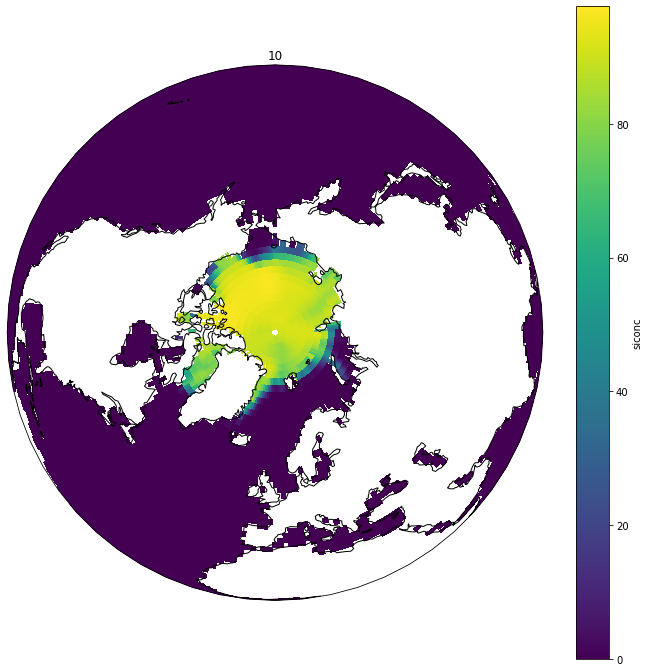

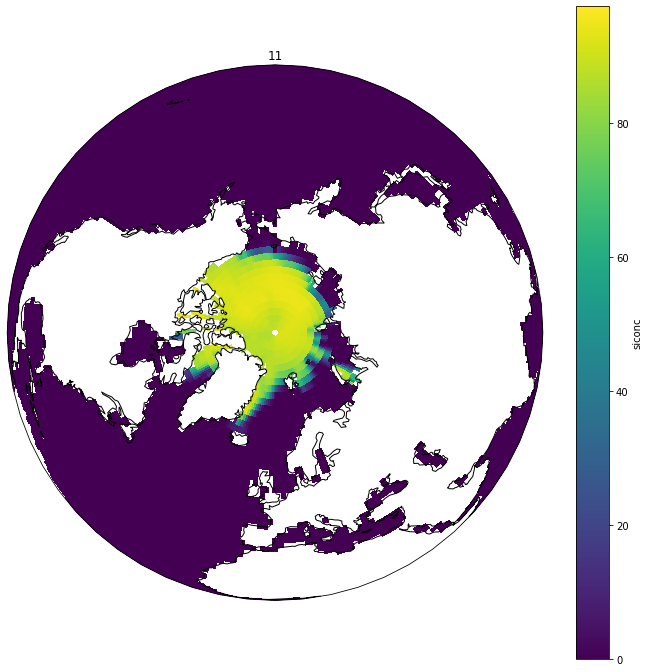

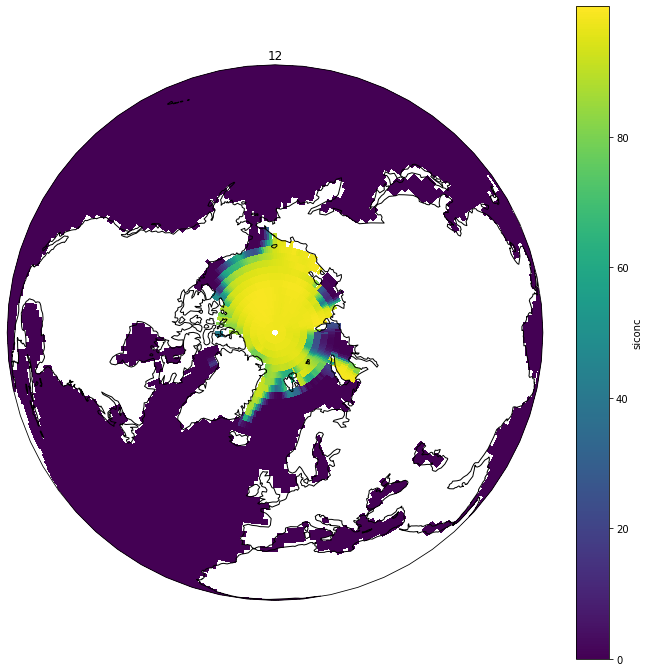

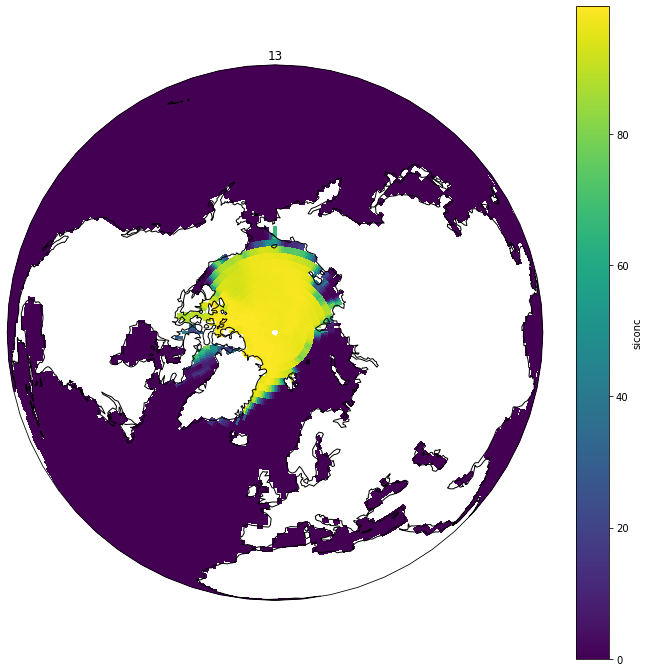

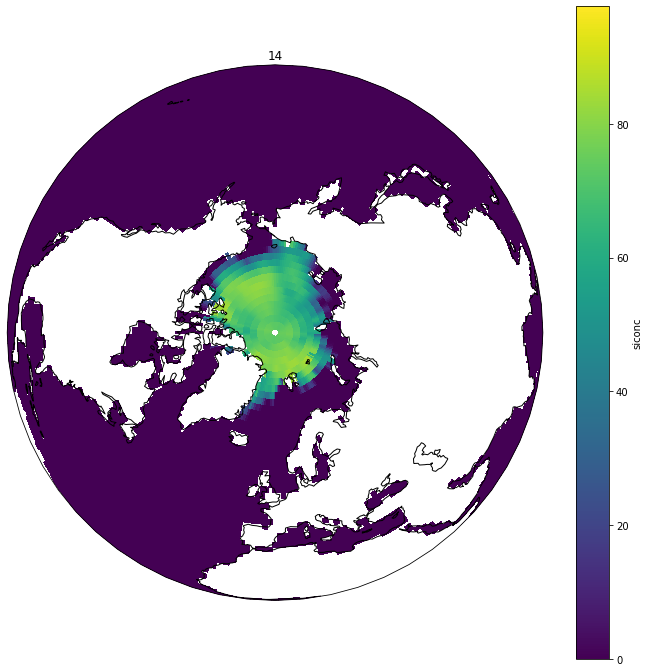

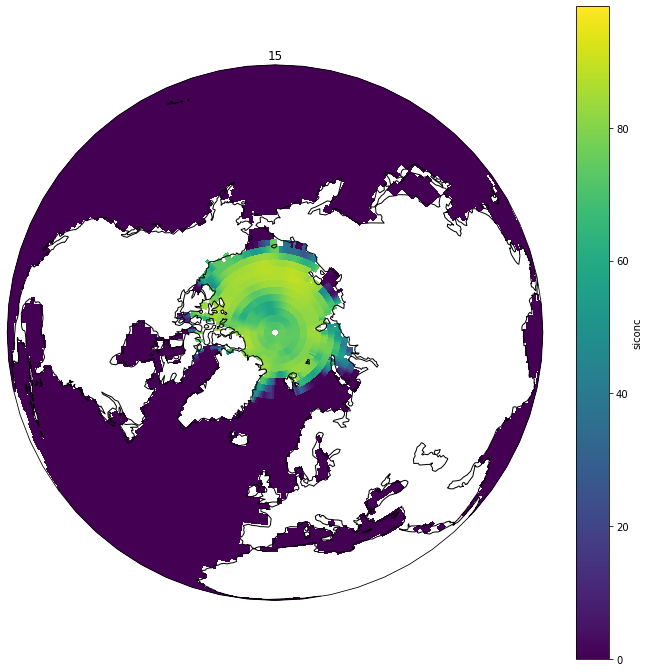

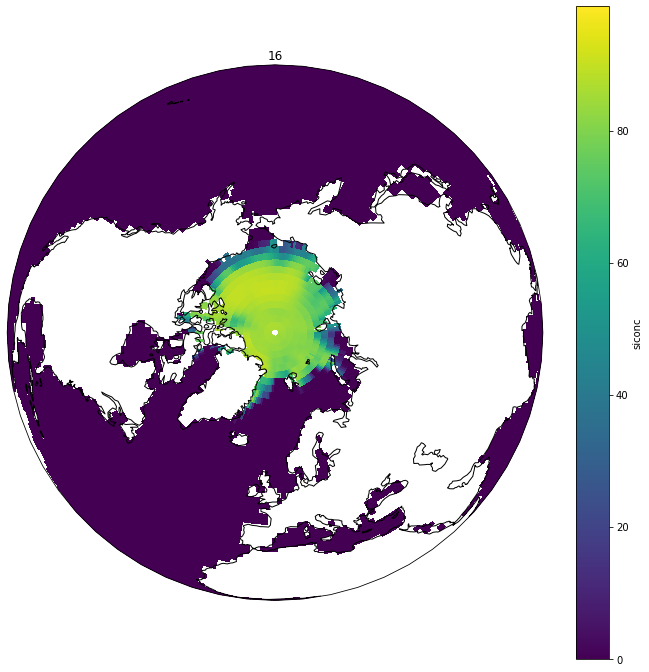

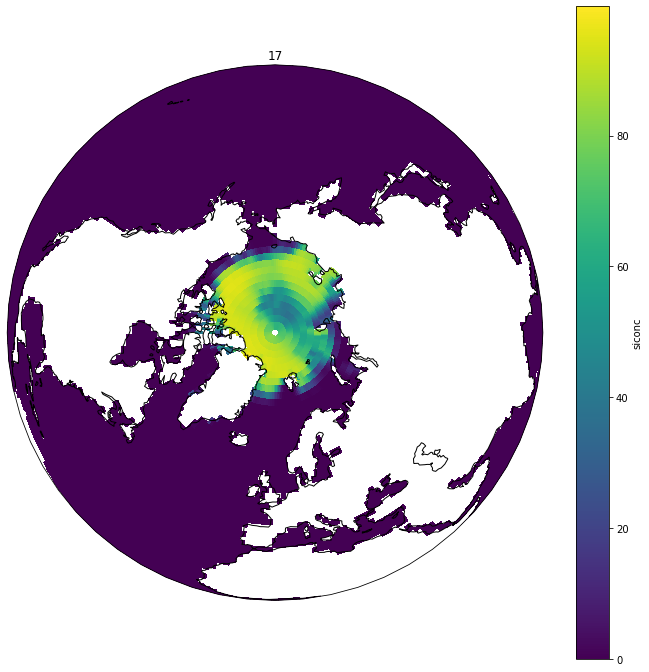

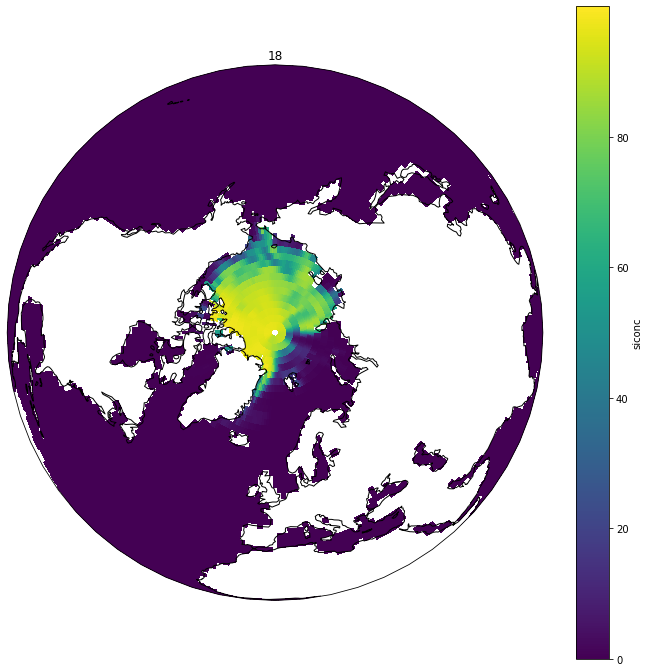

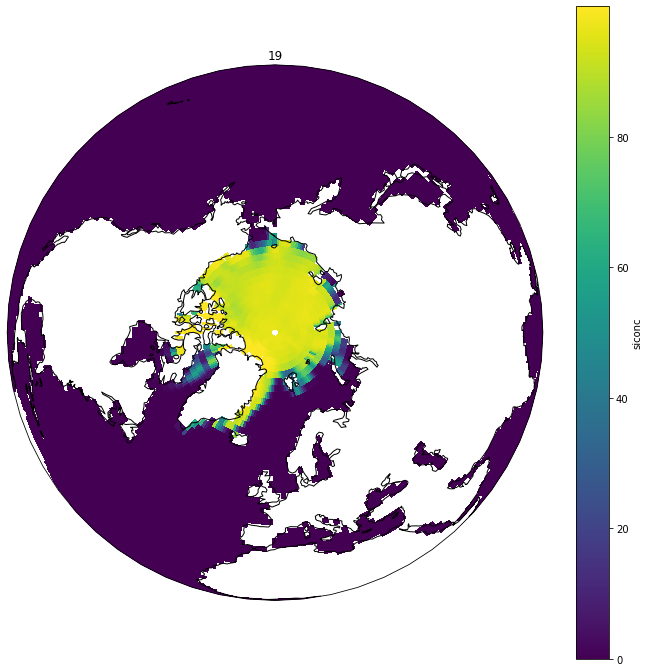

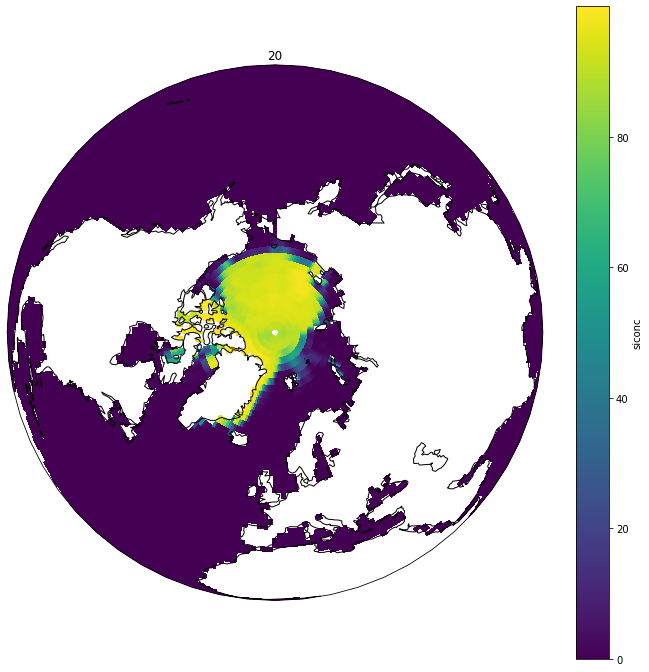

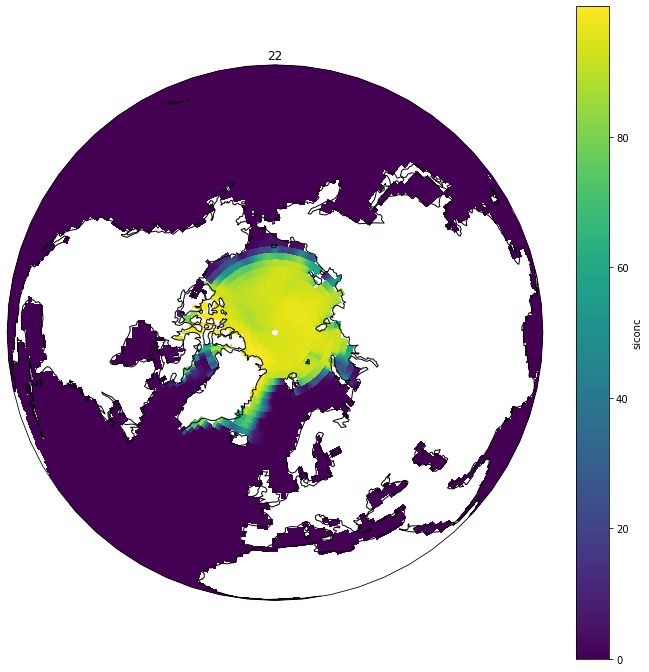

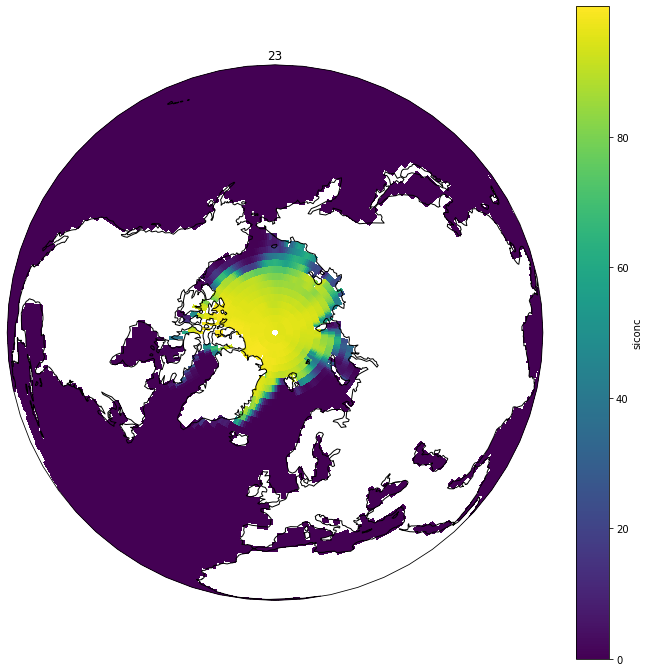

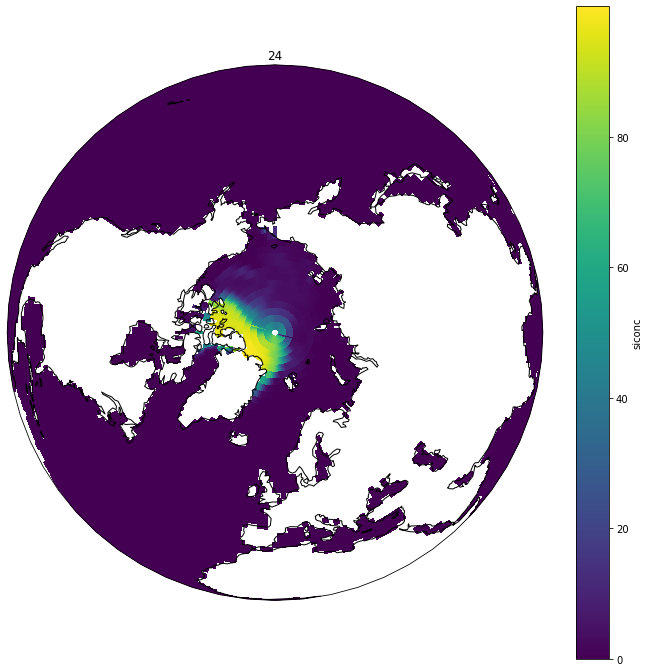

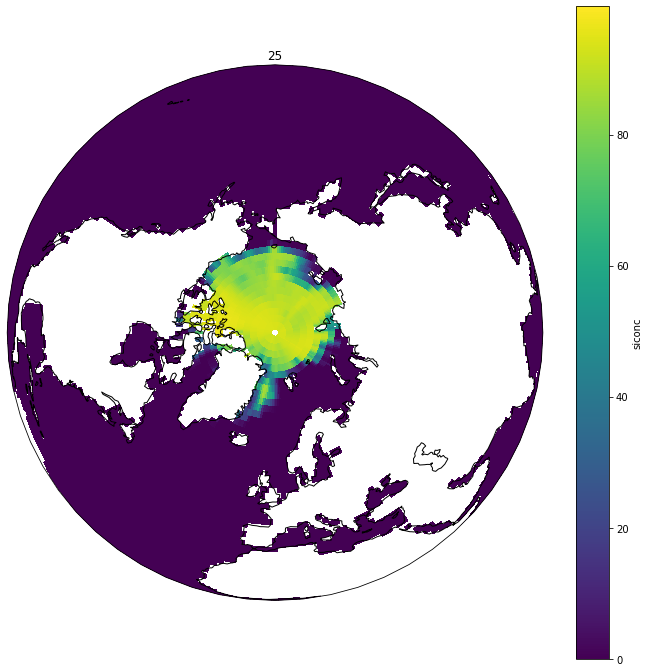

In [20]:
for i,m in enumerate(models):
    if m.SI_masked:     
        fig = plt.figure(figsize=[12,12])

        ax=fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
        m.SI_masked.siconc.isel(time=8).plot(ax = ax, transform=ccrs.PlateCarree())
        plt.title(i)
        ax.coastlines()
    

# Calculate the centers and borders

## create arrays of centers and borders for all regridded models

used $\varepsilon = 0.2$ (and devi=0.5?) for center calculation

In [21]:
#paramters for the center and border algorithms
thlong = 1 #every available point
tstart = 8 #September
tstep = 12 #every year
eps = 0.2


In [22]:
for m in models:
        if m.SI_masked:
                setattr(m,"T_masked", len(m.SI_masked.time.data[tstart::tstep]))
                setattr(m,"n_masked", len(m.SI_masked.lon.data[::thlong]))
                #print(m.n_masked)
        else:
                setattr(m,"T_masked", None)
                setattr(m,"n_masked", None)

In [23]:
for i,m in enumerate(models):
    if m.SI_masked: #for all the models that could be regridded
        print(i)
        filename = "centers_borders_1_5"+m.name
        if os.path.exists(filename):
            print("open existing data")
            cen_bo= xr.open_dataset(filename)
            setattr(m,"centers_1_5", cen_bo.center.data)
            setattr(m,"borders_1_5", cen_bo.border.data) 
        else:
            print('create the dataset')
            centers = np.zeros((m.T_masked,2))
            borders = np.zeros((m.T_masked, 2,m.n_masked))

            for ii,year in enumerate(range(m.T_masked)):
                clo, cla = sib.calc_centre(m.SI_masked,year,epsi=eps, month = tstart,period = tstep )
                centers[ii] = [clo,cla]
                limpoints = sib.get_border(m.SI_masked,year,thlong,clo,cla, exGr=False)
                borders[ii] = limpoints.T

            setattr(m,"centers_1_5", centers)
            setattr(m,"borders_1_5", borders)   

            cen_bo = xr.Dataset({"center": (("t","coord"),centers), 
                    "border": (("t", "coord", "point"),borders)},
                    coords = {"t":np.arange(m.T_masked),
                            "coord": ["lat", "lon"],
                            "point": np.arange(m.n_masked)})
        
            cen_bo.to_netcdf(filename) 
    else:
        setattr(m,"centers_1_5", None)
        setattr(m,"borders_1_5", None)  

1
open existing data
2
open existing data
3
open existing data
4
open existing data
5
open existing data
6
open existing data
8
open existing data
10
open existing data
11
open existing data
12
open existing data
13
open existing data
14
open existing data
15
open existing data
16
open existing data
17
open existing data
18
open existing data
19
open existing data
20
open existing data
22
open existing data
23
open existing data
24
open existing data
25
open existing data


plot some...

/tmp/ipykernel_65160/3516132139.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


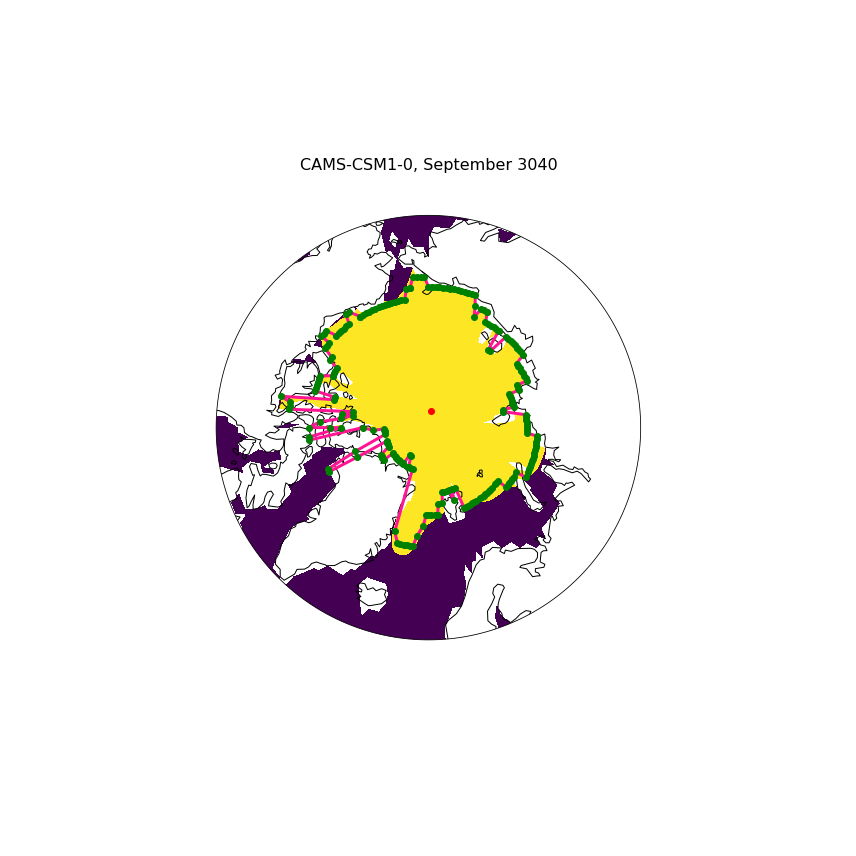

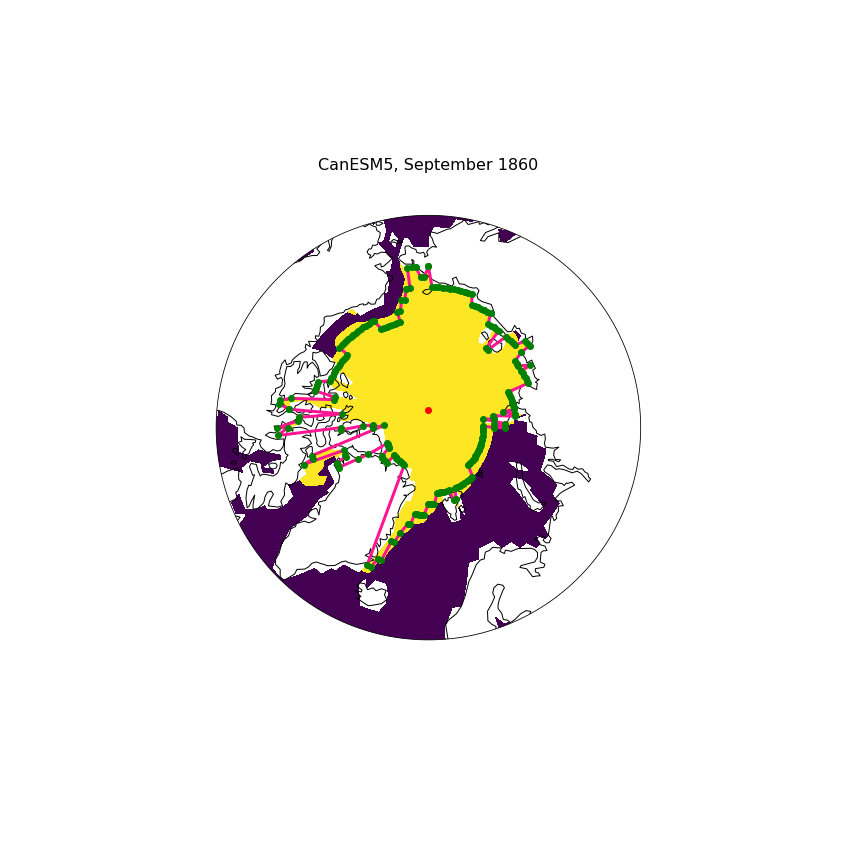

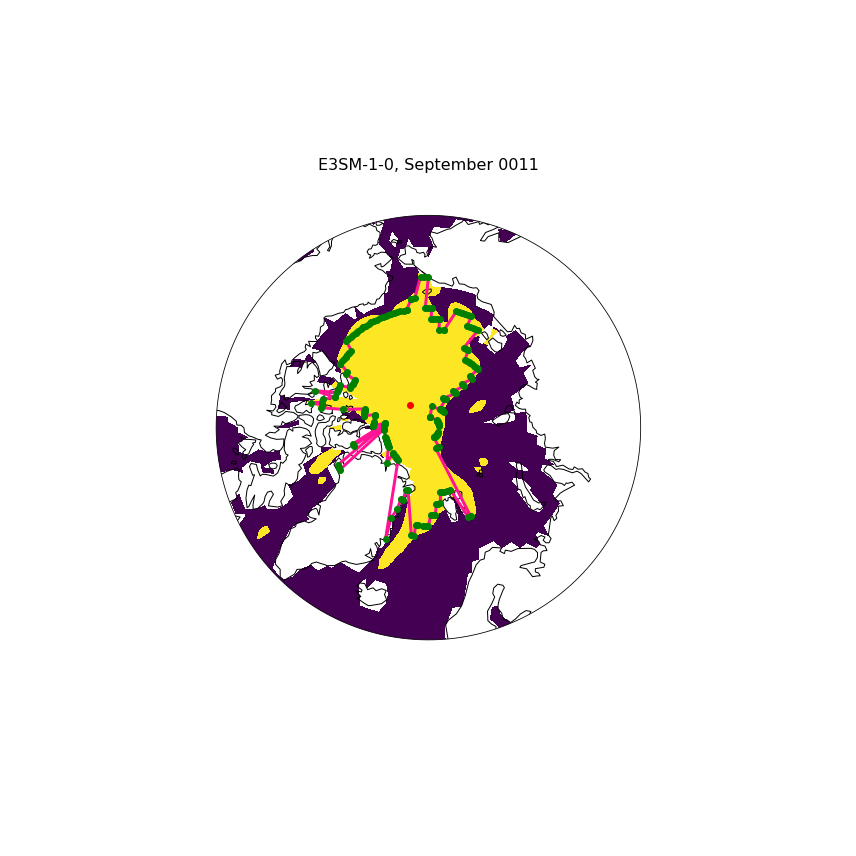

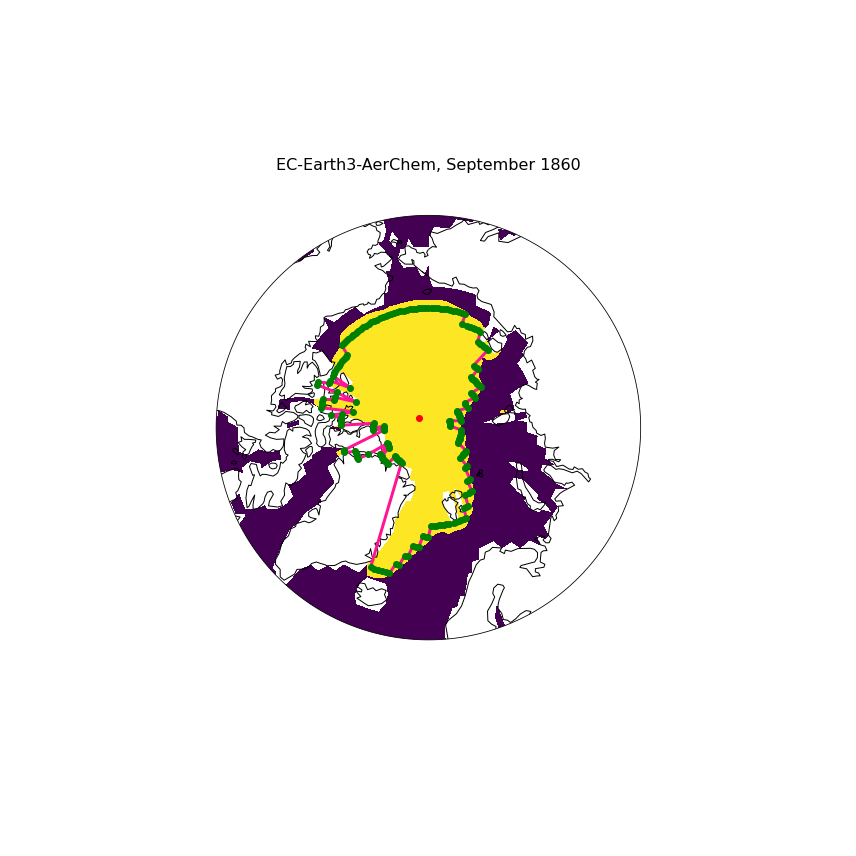

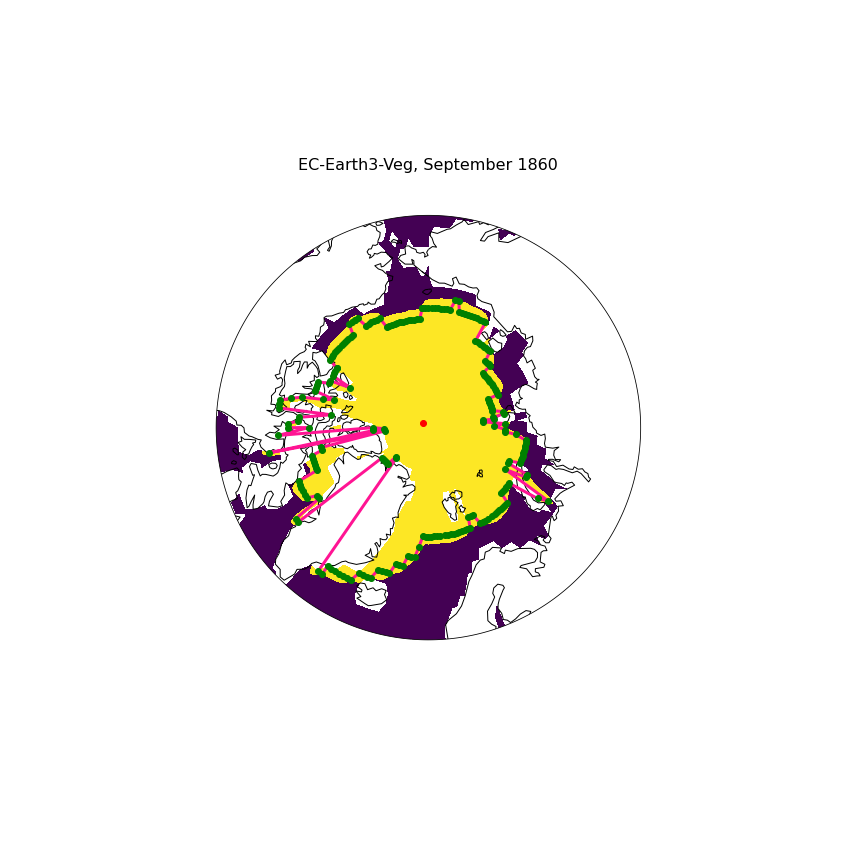

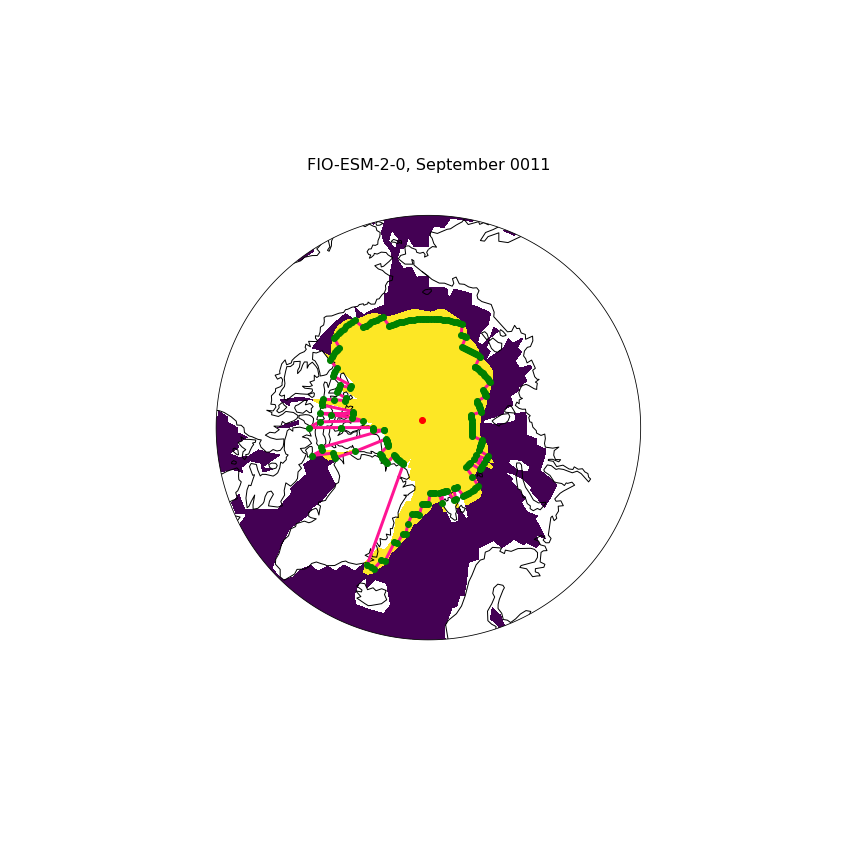

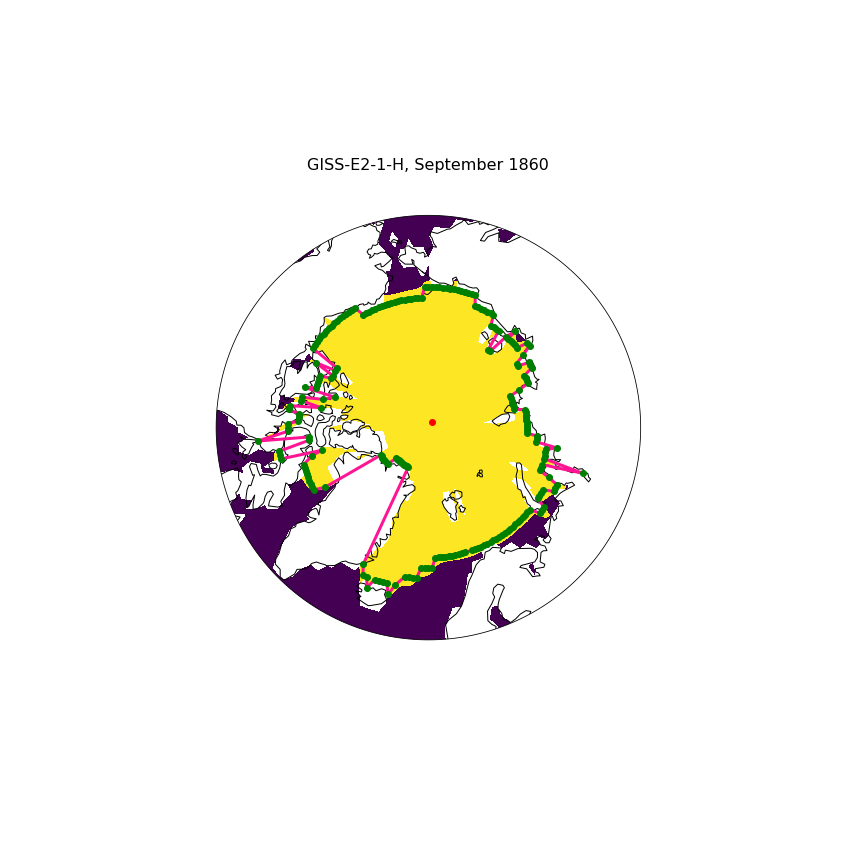

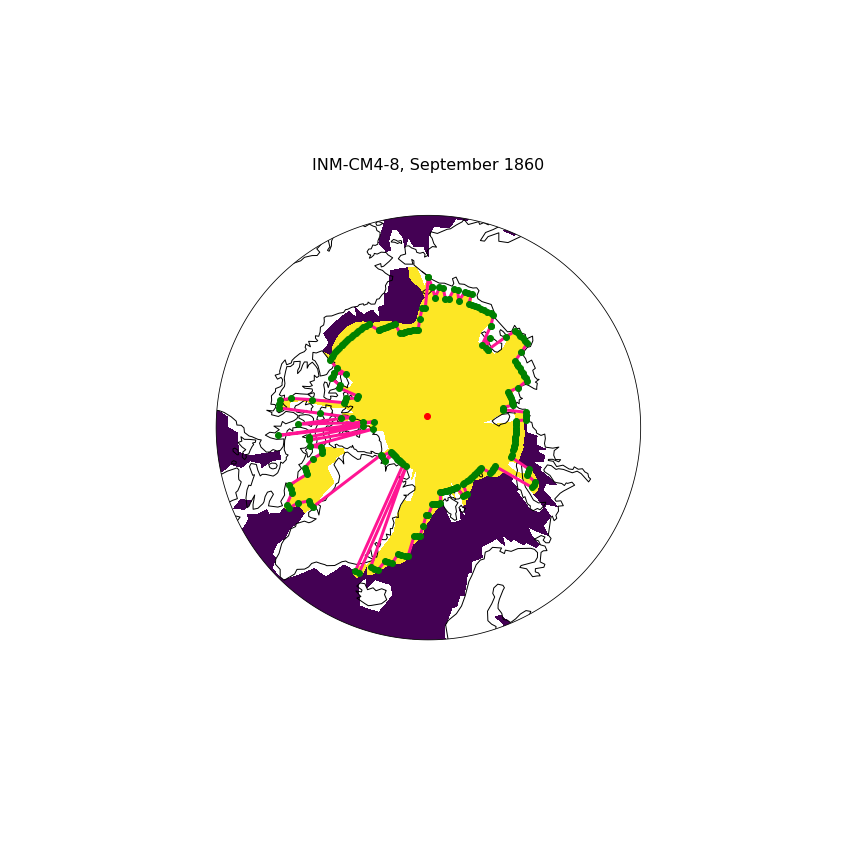

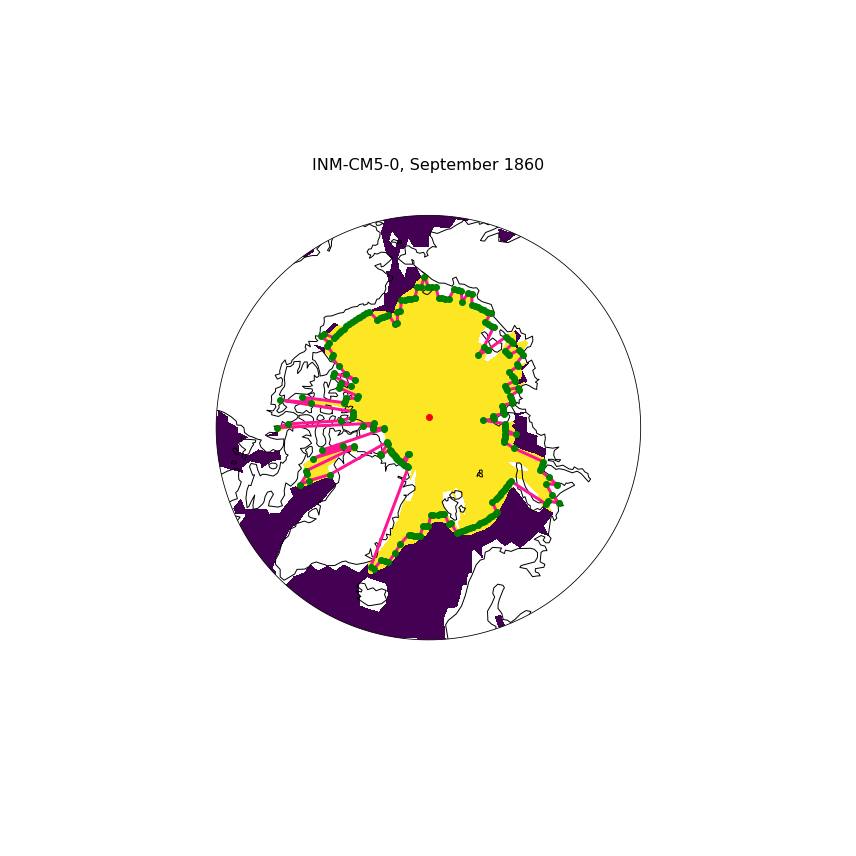

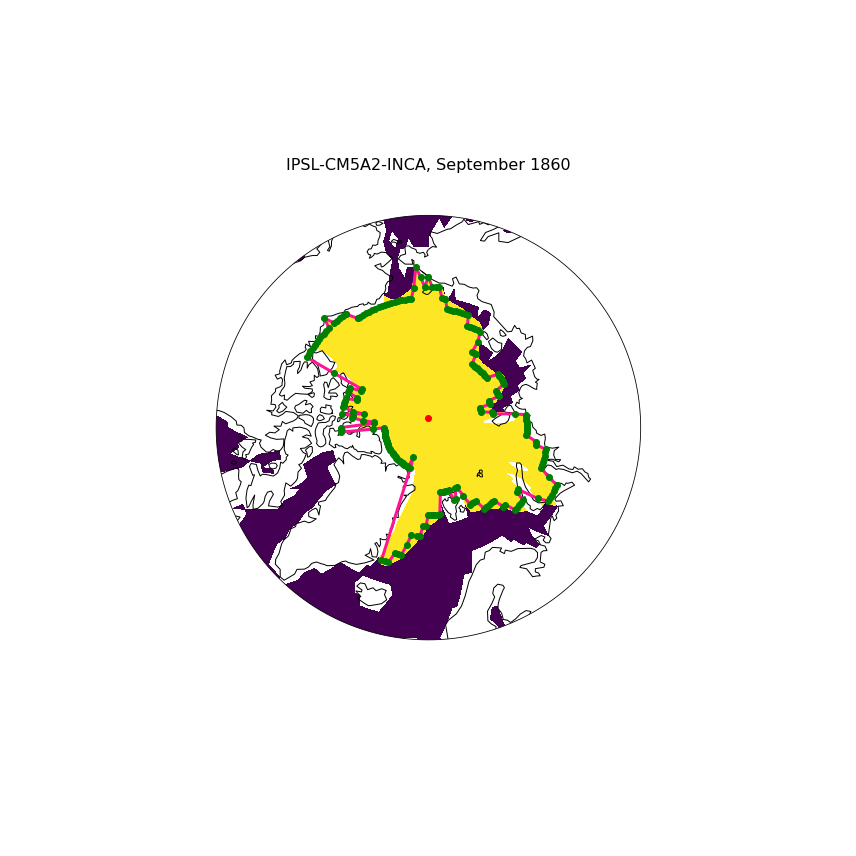

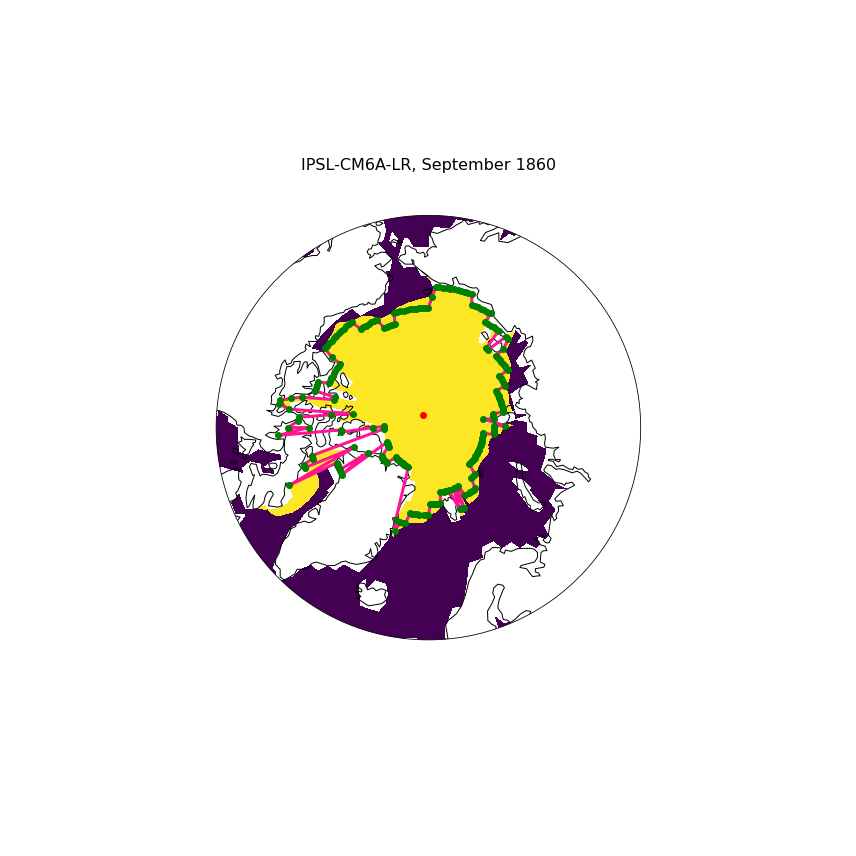

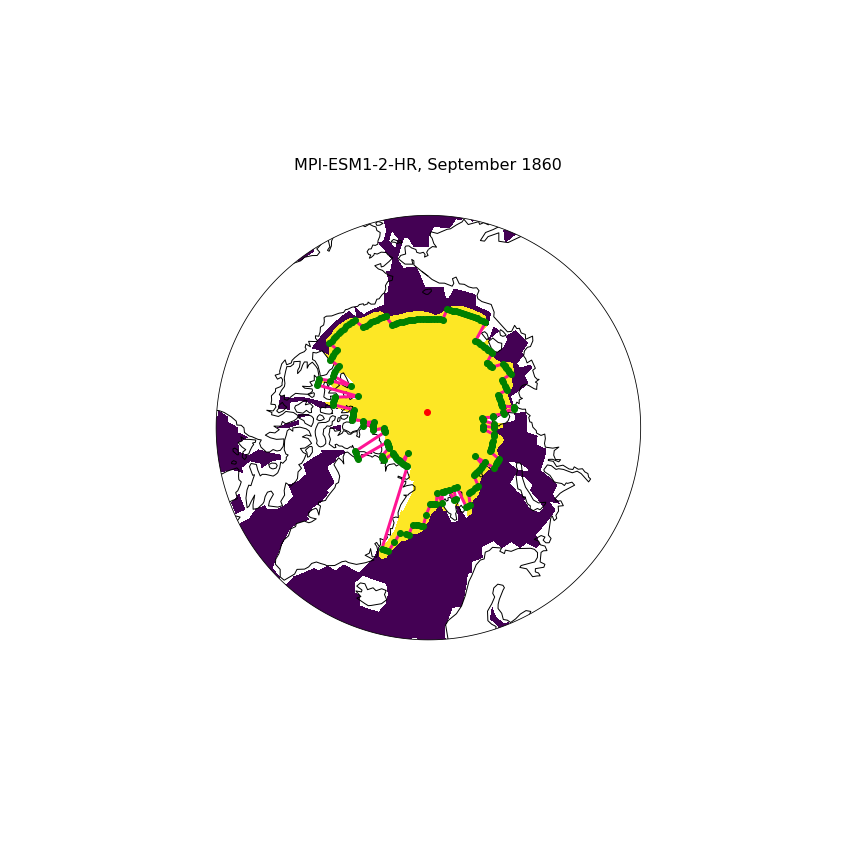

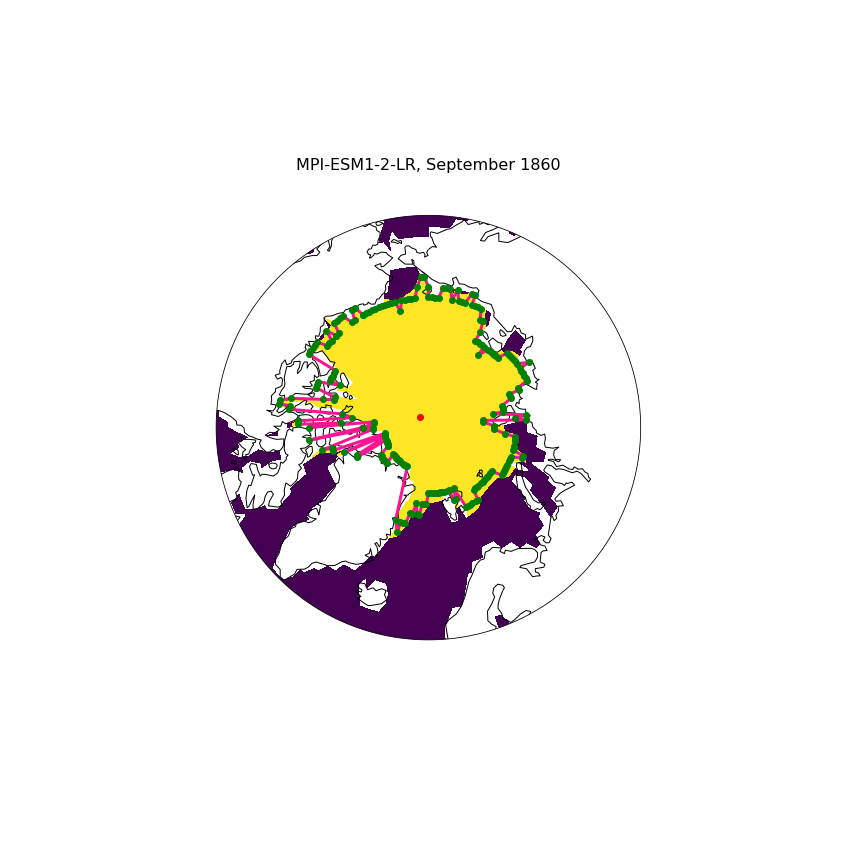

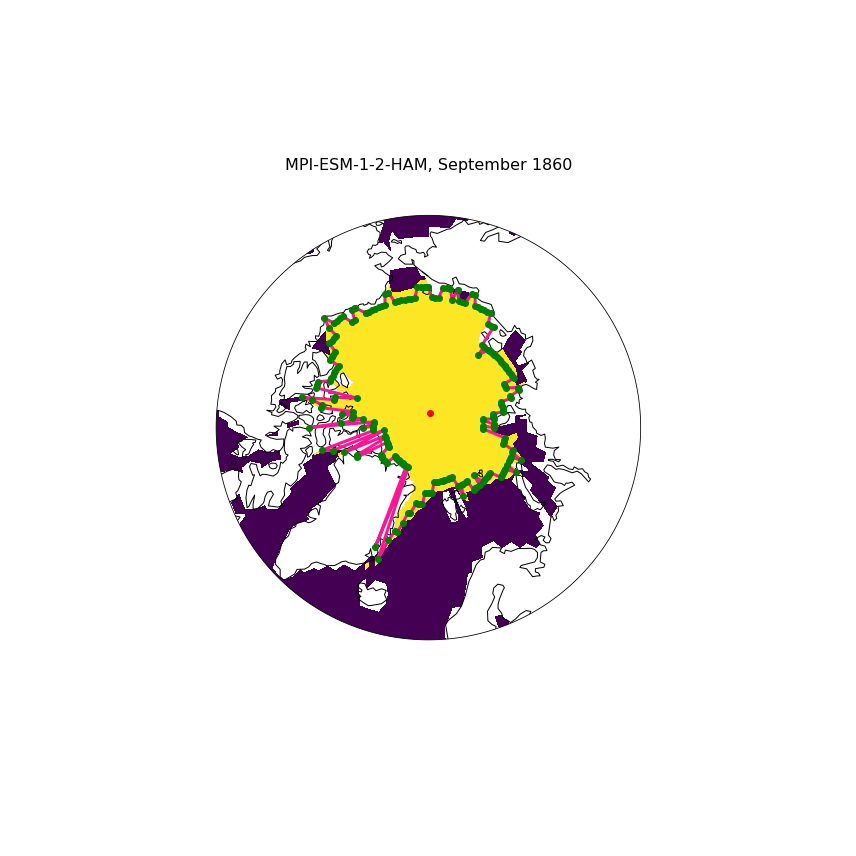

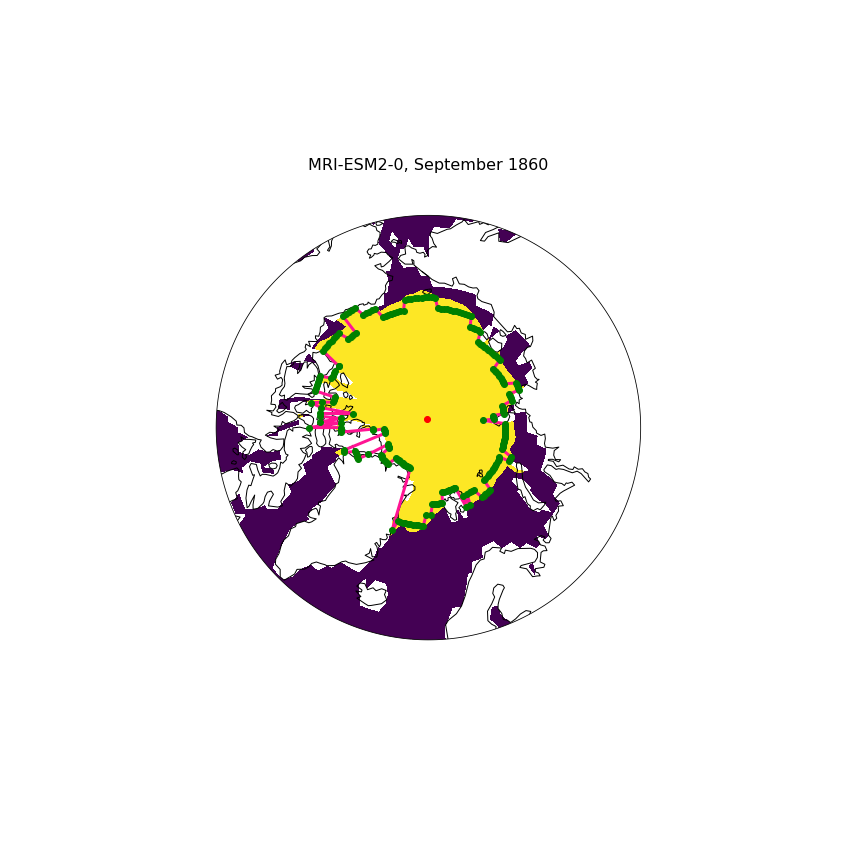

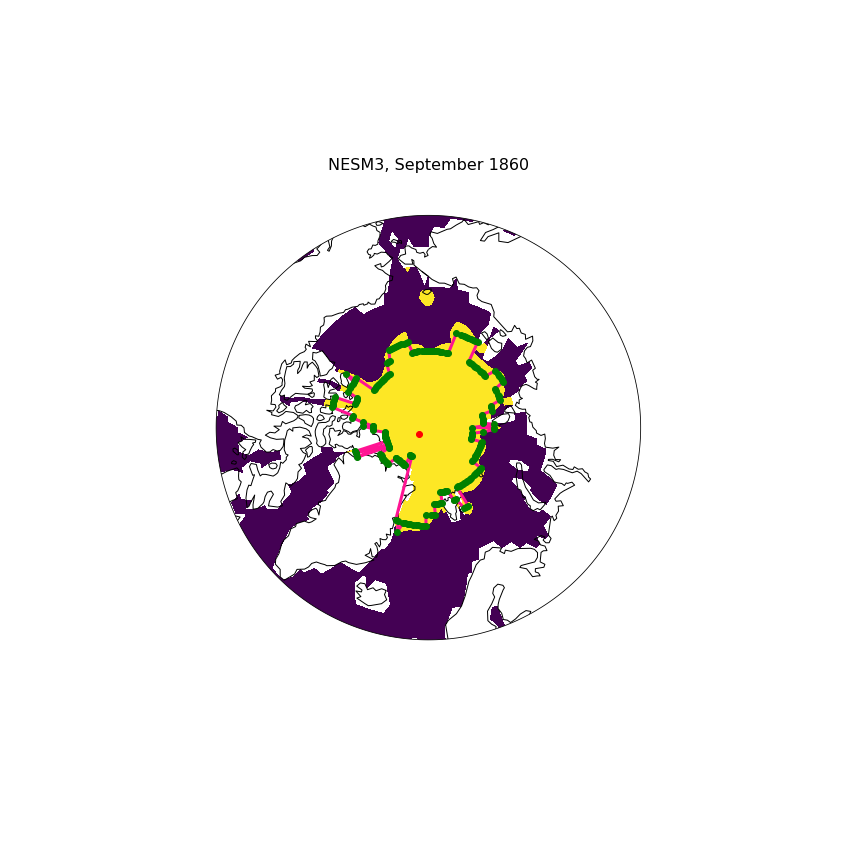

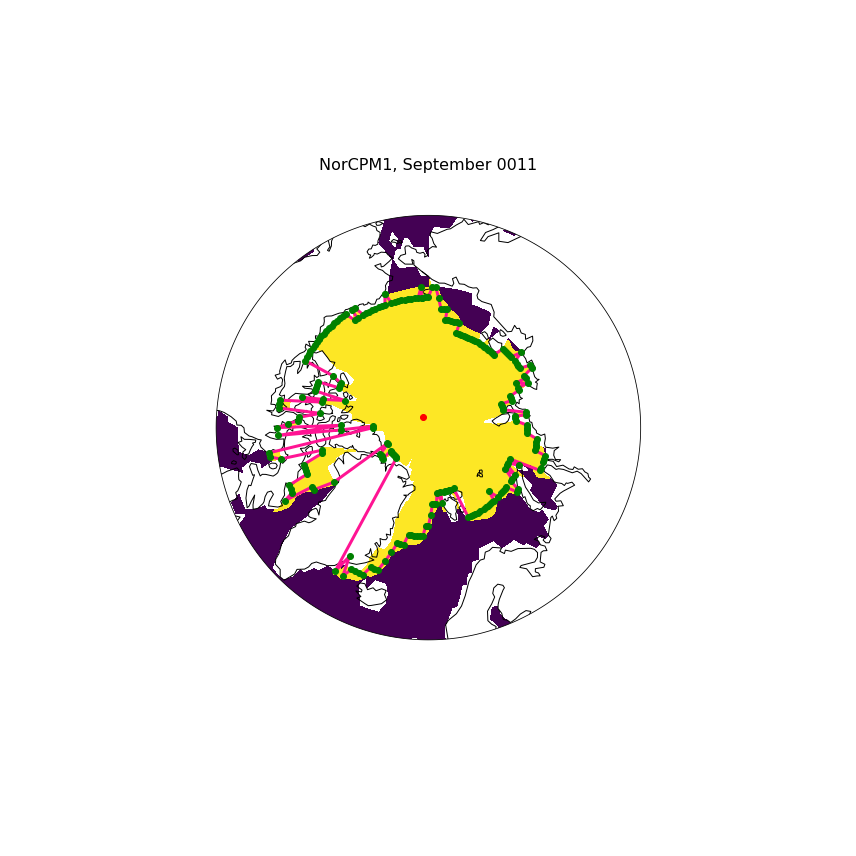

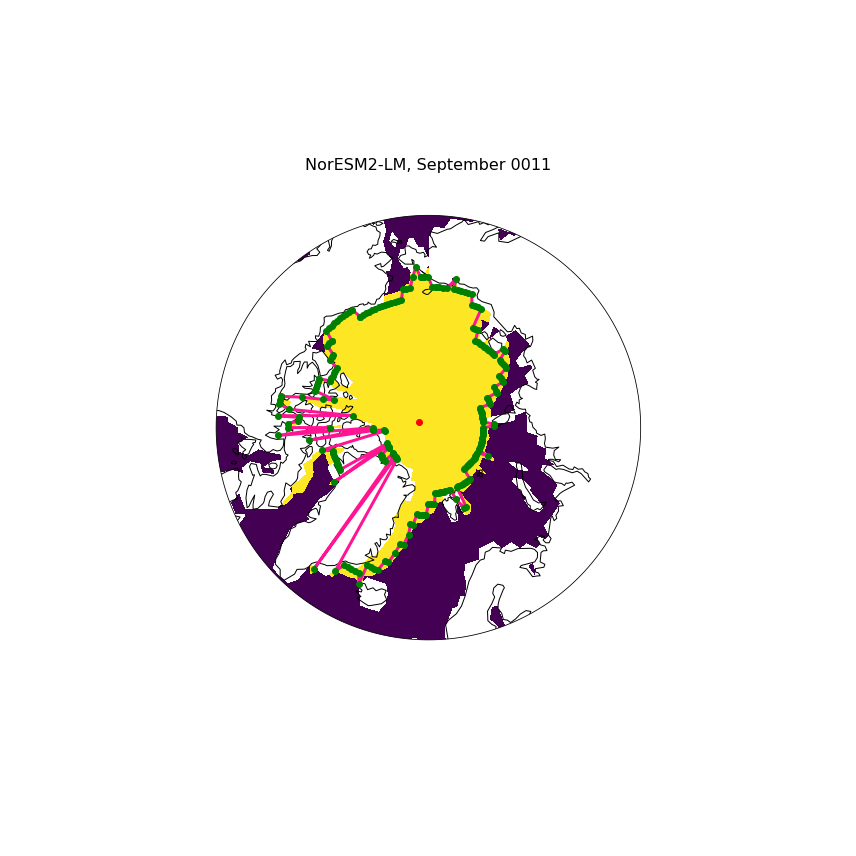

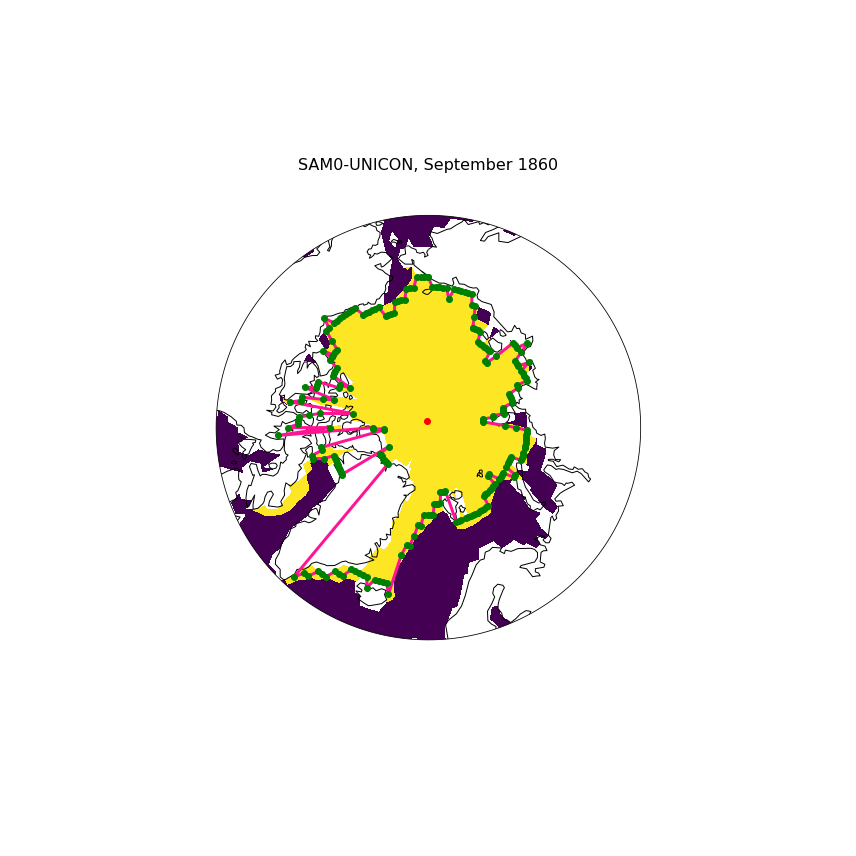

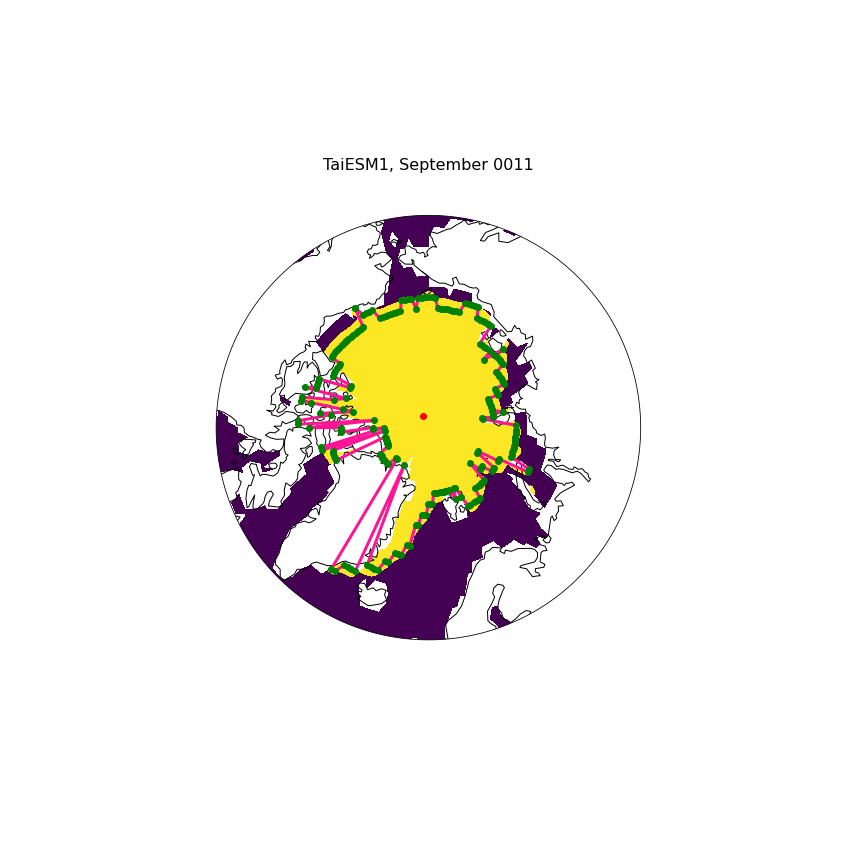

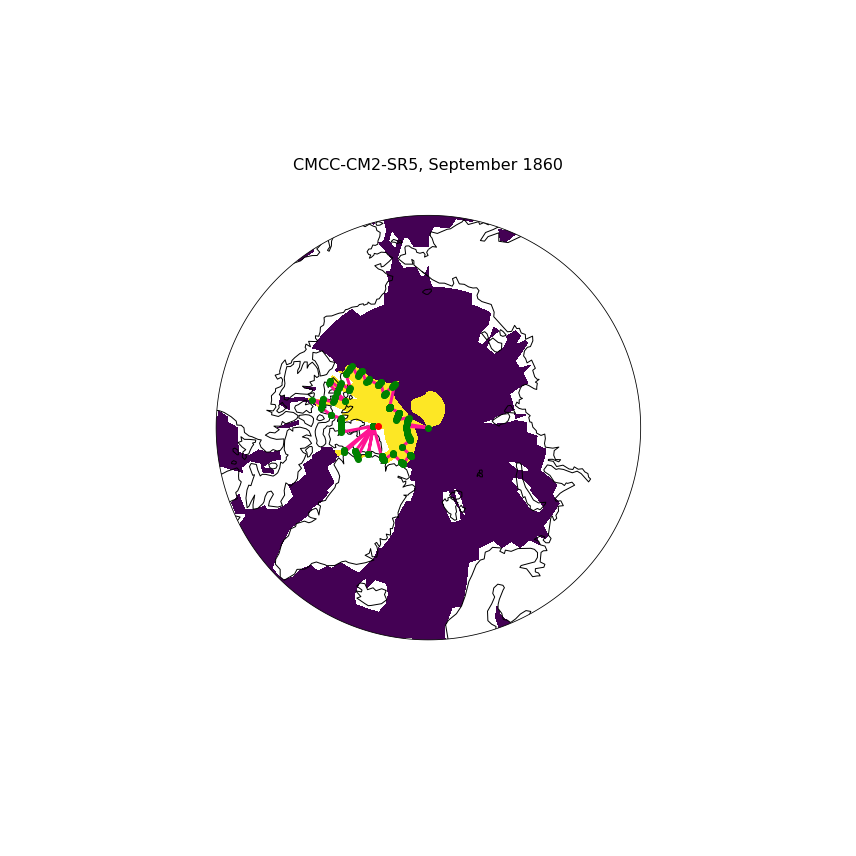

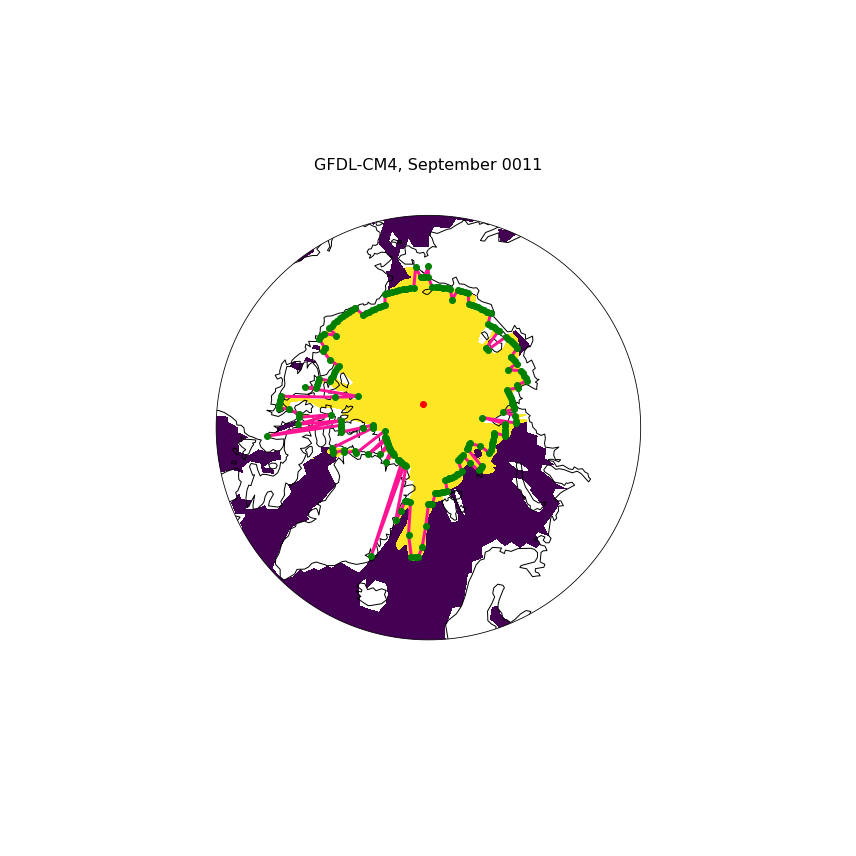

In [24]:

r_limit = 3214068.5
#r_limit = 3224190

year=10#102#70#13
for m in models:
    if m.SI_masked:
#m = models[2]#11
        fig = plt.figure(figsize=[12,12])

        ax=fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
        #im = m.SI_masked.siconc.isel(time=year*12+8).plot(ax=ax,transform=ccrs.PlateCarree())#, cmap='Blues_r')
        im = m.SI_masked.siconc.isel(time=year*12+8).plot.contourf(ax=ax,transform=ccrs.PlateCarree(),  levels = np.linspace(0, 15.0, 2))#, cmap='Reds_r')
        #gls = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), lw=3, color="gold",
        #        y_inline=True, xlocs=range(-180,180,30), ylocs=range(-80,91,10))


        #plot circumference
        ax.plot(m.borders_1_5[year,0],m.borders_1_5[year,1],color="deeppink", linewidth=3, transform = ccrs.Geodetic())
        ax.plot([m.borders_1_5[year,0,-1],m.borders_1_5[year,0,0]],[m.borders_1_5[year,1,-1],m.borders_1_5[year,1,0]],color="deeppink", linewidth=3, transform = ccrs.Geodetic()) 
        #plot borderpoints
        ax.plot(m.borders_1_5[year,0],m.borders_1_5[year,1],color="green", linewidth=0,marker="o", transform = ccrs.Geodetic()) 
        #plot centerpoint
        ax.plot(m.centers_1_5[year,0],m.centers_1_5[year,1],color="red",linewidth=0,marker='o',transform=ccrs.Geodetic()) 
        ax.coastlines()

        circle_path = mpath.Path.unit_circle()
        circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,
                                circle_path.codes.copy())
        ax.set_boundary(circle_path)

        im.colorbar.remove()
        #plt.colorbar(im,shrink=0.5, pad=-0.2)
        #plt.colorbar(im,fraction=0.046, pad=0.04)
        #im.colorbar.set_label("Sea Ice Area Fraction \n (Ocean Grid) [%]", fontsize=14)

        plt.title(m.name + ", " + m.model.time.values[year*12 +8].strftime("%B %Y"), fontsize=16,y=0.8);
        plt.tight_layout()
        #plt.show()

#plt.savefig("nice_sic_sept.png")